## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/caco/caco_maccs_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train_all = df_train_all['permeability']

X_train = df_train.loc[:, df_train.columns != 'permeability']
y_train = df_train['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

X_valid = df_valid.loc[:, df_valid.columns != 'permeability']
y_valid = df_valid['permeability']

In [5]:
X_train.shape

(2460, 166)

In [6]:
X_test.shape

(704, 166)

In [7]:
X_valid.shape

(351, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [9]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [10]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=351, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 843.1721693757293, Accuracy: -0.1758585801135128
Test Avg. loss: 819.4151611328125, Accuracy: 0.11358369661000267
################## EPOCH 2 ##################
Train Avg. loss: 772.6827675955636, Accuracy: -0.1070716254413962
Test Avg. loss: 799.8623657226562, Accuracy: 0.1347353119283926
################## EPOCH 3 ##################
Train Avg. loss: 733.3559178934469, Accuracy: -0.11902359647204502
Test Avg. loss: 744.3311157226562, Accuracy: 0.19480718177876677
################## EPOCH 4 ##################
Train Avg. loss: 722.4421859344878, Accuracy: -0.124442348803598
Test Avg. loss: 644.9051513671875, Accuracy: 0.3023629572326676
################## EPOCH 5 ##################
Train Avg. loss: 625.5801599675959, Accuracy: -0.13453003096153326
Test Avg. loss: 574.1768798828125, Accuracy: 0.37887438887091274
################## EPOCH 6 ##################
Train Avg. loss: 666.770218390923, Accu

Train Avg. loss: 306.40119250409015, Accuracy: 0.18024075050195815
Test Avg. loss: 426.52783203125, Accuracy: 0.5385962644816698
################## EPOCH 48 ##################
Train Avg. loss: 313.1196616036551, Accuracy: 0.334525294819458
Test Avg. loss: 375.80010986328125, Accuracy: 0.5934718171349056
################## EPOCH 49 ##################
Train Avg. loss: 325.4948833019702, Accuracy: 0.23519525646884615
Test Avg. loss: 366.8522033691406, Accuracy: 0.6031514040879908
################## EPOCH 50 ##################
Train Avg. loss: 334.55394130558165, Accuracy: 0.26557926342527277
Test Avg. loss: 379.9068298339844, Accuracy: 0.5890293557303723
################## EPOCH 51 ##################
Train Avg. loss: 352.1034828285118, Accuracy: 0.27081771218921713
Test Avg. loss: 380.33502197265625, Accuracy: 0.5885661345721116
################## EPOCH 52 ##################
Train Avg. loss: 290.2786117652794, Accuracy: 0.39781958216886365
Test Avg. loss: 425.97479248046875, Accuracy: 0.5

Train Avg. loss: 260.0933830459397, Accuracy: 0.4405313571491568
Test Avg. loss: 427.0150146484375, Accuracy: 0.5380692813311465
################## EPOCH 95 ##################
Train Avg. loss: 223.65730320323598, Accuracy: 0.5135098941028353
Test Avg. loss: 415.14056396484375, Accuracy: 0.5509146128202913
################## EPOCH 96 ##################
Train Avg. loss: 235.2607639857701, Accuracy: 0.5131491288256079
Test Avg. loss: 417.2552185058594, Accuracy: 0.5486270903350583
################## EPOCH 97 ##################
Train Avg. loss: 225.92460533241172, Accuracy: 0.48566051997757725
Test Avg. loss: 423.3992004394531, Accuracy: 0.541980693890268
################## EPOCH 98 ##################
Train Avg. loss: 242.91122481110807, Accuracy: 0.46225214861233177
Test Avg. loss: 423.68524169921875, Accuracy: 0.541671299122853
################## EPOCH 99 ##################
Train Avg. loss: 269.8720164608646, Accuracy: 0.43006219935625417
Test Avg. loss: 472.11492919921875, Accuracy: 0.4

Train Avg. loss: 211.06689894044555, Accuracy: 0.5352095917038957
Test Avg. loss: 371.9809875488281, Accuracy: 0.5976032304193344
################## EPOCH 142 ##################
Train Avg. loss: 209.05464350712765, Accuracy: 0.5150829891326292
Test Avg. loss: 369.350830078125, Accuracy: 0.6004484418348376
################## EPOCH 143 ##################
Train Avg. loss: 232.1351100376674, Accuracy: 0.5530524705223283
Test Avg. loss: 364.3840026855469, Accuracy: 0.6058214038099713
################## EPOCH 144 ##################
Train Avg. loss: 224.17004969212917, Accuracy: 0.47435343951188574
Test Avg. loss: 477.0499572753906, Accuracy: 0.48394310213942304
################## EPOCH 145 ##################
Train Avg. loss: 230.2770198475231, Accuracy: 0.54338188305107
Test Avg. loss: 387.8228759765625, Accuracy: 0.5804660342237564
################## EPOCH 146 ##################
Train Avg. loss: 217.51894343983042, Accuracy: 0.5637852488754378
Test Avg. loss: 359.8654479980469, Accuracy: 0.

Train Avg. loss: 223.22872092507103, Accuracy: 0.5695192104146887
Test Avg. loss: 352.1243591308594, Accuracy: 0.6190834906013643
################## EPOCH 189 ##################
Train Avg. loss: 199.39527724625228, Accuracy: 0.5878532351221881
Test Avg. loss: 364.0177917480469, Accuracy: 0.6062175582766848
################## EPOCH 190 ##################
Train Avg. loss: 238.49836394074674, Accuracy: 0.5649342562481174
Test Avg. loss: 377.5233154296875, Accuracy: 0.5916077438317755
################## EPOCH 191 ##################
Train Avg. loss: 182.125566061441, Accuracy: 0.5884587625963525
Test Avg. loss: 376.6119079589844, Accuracy: 0.5925936622330096
################## EPOCH 192 ##################
Train Avg. loss: 190.07492015888164, Accuracy: 0.6021400540504217
Test Avg. loss: 401.0395812988281, Accuracy: 0.5661686567252108
################## EPOCH 193 ##################
Train Avg. loss: 183.26811312390612, Accuracy: 0.6115564885100255
Test Avg. loss: 368.90423583984375, Accuracy: 

Train Avg. loss: 170.6053228997565, Accuracy: 0.6093162099576951
Test Avg. loss: 383.5255432128906, Accuracy: 0.5851147557329079
################## EPOCH 236 ##################
Train Avg. loss: 174.94379301195022, Accuracy: 0.6284287395632433
Test Avg. loss: 428.0360107421875, Accuracy: 0.5369647407849322
################## EPOCH 237 ##################
Train Avg. loss: 186.92797361101424, Accuracy: 0.5952809491942564
Test Avg. loss: 450.95819091796875, Accuracy: 0.5121683394262206
################## EPOCH 238 ##################
Train Avg. loss: 172.42747116088867, Accuracy: 0.6428546304448226
Test Avg. loss: 421.4930419921875, Accuracy: 0.5440427524492235
################## EPOCH 239 ##################
Train Avg. loss: 171.77152871466302, Accuracy: 0.6335301407474074
Test Avg. loss: 388.48431396484375, Accuracy: 0.5797504810688805
################## EPOCH 240 ##################
Train Avg. loss: 156.06837760628045, Accuracy: 0.6709900976216117
Test Avg. loss: 417.9382629394531, Accuracy

Train Avg. loss: 154.85433910419414, Accuracy: 0.6601102131431595
Test Avg. loss: 334.13653564453125, Accuracy: 0.6385421232977881
################## EPOCH 283 ##################
Train Avg. loss: 140.01324611515193, Accuracy: 0.6746583246229442
Test Avg. loss: 313.4769287109375, Accuracy: 0.6608910170179174
################## EPOCH 284 ##################
Train Avg. loss: 149.455061924922, Accuracy: 0.6673572506381223
Test Avg. loss: 360.4718933105469, Accuracy: 0.6100534478261794
################## EPOCH 285 ##################
Train Avg. loss: 166.91196065134815, Accuracy: 0.6551967653533304
Test Avg. loss: 338.1917419433594, Accuracy: 0.6341553127450048
################## EPOCH 286 ##################
Train Avg. loss: 143.12095632181538, Accuracy: 0.6667906376432527
Test Avg. loss: 328.9661560058594, Accuracy: 0.6441352654784186
################## EPOCH 287 ##################
Train Avg. loss: 156.5467771059507, Accuracy: 0.6773975048579531
Test Avg. loss: 348.83892822265625, Accuracy: 

Train Avg. loss: 419.61260595077124, Accuracy: 0.3250821665197486
Test Avg. loss: 410.271240234375, Accuracy: 0.556182105671672
################## EPOCH 30 ##################
Train Avg. loss: 439.49464436066455, Accuracy: 0.25598082901908564
Test Avg. loss: 369.7872009277344, Accuracy: 0.5999763909138749
################## EPOCH 31 ##################
Train Avg. loss: 377.7616313054011, Accuracy: 0.37532570643167606
Test Avg. loss: 461.5777282714844, Accuracy: 0.5006804604455435
################## EPOCH 32 ##################
Train Avg. loss: 371.24903263189856, Accuracy: 0.34390374924349837
Test Avg. loss: 482.1382751464844, Accuracy: 0.4784387669194108
################## EPOCH 33 ##################
Train Avg. loss: 357.31140850751825, Accuracy: 0.4148519313670192
Test Avg. loss: 466.1295471191406, Accuracy: 0.4957564753653484
################## EPOCH 34 ##################
Train Avg. loss: 380.14039905254657, Accuracy: 0.32434215402472877
Test Avg. loss: 437.7810363769531, Accuracy: 0.5

Train Avg. loss: 280.6992979783278, Accuracy: 0.5360193093732247
Test Avg. loss: 466.129638671875, Accuracy: 0.4957563178199048
################## EPOCH 77 ##################
Train Avg. loss: 306.47718556722003, Accuracy: 0.47565672348966587
Test Avg. loss: 433.7793884277344, Accuracy: 0.530751726416377
################## EPOCH 78 ##################
Train Avg. loss: 279.66111344557544, Accuracy: 0.5486071816110429
Test Avg. loss: 447.07354736328125, Accuracy: 0.5163706579947177
################## EPOCH 79 ##################
Train Avg. loss: 282.1113967895508, Accuracy: 0.5167106547176228
Test Avg. loss: 478.8166809082031, Accuracy: 0.4820318762115178
################## EPOCH 80 ##################
Train Avg. loss: 298.6514483720828, Accuracy: 0.5102904959557397
Test Avg. loss: 473.64263916015625, Accuracy: 0.48762907347439777
################## EPOCH 81 ##################
Train Avg. loss: 285.89409715701373, Accuracy: 0.5389652256761054
Test Avg. loss: 456.5561828613281, Accuracy: 0.506

Train Avg. loss: 250.57699037209537, Accuracy: 0.5616973814804179
Test Avg. loss: 469.0540771484375, Accuracy: 0.4925928260272443
################## EPOCH 125 ##################
Train Avg. loss: 234.6307862110627, Accuracy: 0.5796466326049675
Test Avg. loss: 426.3680419921875, Accuracy: 0.5387691113690993
################## EPOCH 126 ##################
Train Avg. loss: 240.96183141072592, Accuracy: 0.5946230187029051
Test Avg. loss: 467.3172912597656, Accuracy: 0.4944715759122642
################## EPOCH 127 ##################
Train Avg. loss: 239.5107175386869, Accuracy: 0.5800001175477209
Test Avg. loss: 441.7582702636719, Accuracy: 0.5221205215148047
################## EPOCH 128 ##################
Train Avg. loss: 254.7238532824394, Accuracy: 0.5898449564393835
Test Avg. loss: 463.60931396484375, Accuracy: 0.4984827310136988
################## EPOCH 129 ##################
Train Avg. loss: 257.36799778082434, Accuracy: 0.6083720314554975
Test Avg. loss: 449.79888916015625, Accuracy: 

Train Avg. loss: 214.33377759884564, Accuracy: 0.6426481290668826
Test Avg. loss: 448.4756164550781, Accuracy: 0.5148538937877072
################## EPOCH 172 ##################
Train Avg. loss: 231.4176029303135, Accuracy: 0.5877318846657045
Test Avg. loss: 445.2495422363281, Accuracy: 0.518343724879194
################## EPOCH 173 ##################
Train Avg. loss: 188.05475479517227, Accuracy: 0.6740322825248369
Test Avg. loss: 383.4882507324219, Accuracy: 0.5851551087490442
################## EPOCH 174 ##################
Train Avg. loss: 179.968144539075, Accuracy: 0.7020408409681258
Test Avg. loss: 443.05859375, Accuracy: 0.5207138708850252
################## EPOCH 175 ##################
Train Avg. loss: 191.2209730881911, Accuracy: 0.6716526715737137
Test Avg. loss: 457.20684814453125, Accuracy: 0.5054087071580216
################## EPOCH 176 ##################
Train Avg. loss: 204.52779290614984, Accuracy: 0.6538235230859629
Test Avg. loss: 484.9652404785156, Accuracy: 0.475380

Train Avg. loss: 184.07513760297726, Accuracy: 0.6866427800252383
Test Avg. loss: 467.09674072265625, Accuracy: 0.49471019631697943
################## EPOCH 219 ##################
Train Avg. loss: 193.9270555545122, Accuracy: 0.6950113206067364
Test Avg. loss: 405.6435546875, Accuracy: 0.5611882144446247
################## EPOCH 220 ##################
Train Avg. loss: 196.91180165608725, Accuracy: 0.6913975650036139
Test Avg. loss: 414.4752502441406, Accuracy: 0.5516343529373124
################## EPOCH 221 ##################
Train Avg. loss: 197.8802946041792, Accuracy: 0.6739716109260205
Test Avg. loss: 415.8891906738281, Accuracy: 0.5501047684821521
################## EPOCH 222 ##################
Train Avg. loss: 209.6280393355932, Accuracy: 0.6669269007130707
Test Avg. loss: 392.354248046875, Accuracy: 0.5755641630891892
################## EPOCH 223 ##################
Train Avg. loss: 180.8026699163975, Accuracy: 0.7026902185026663
Test Avg. loss: 399.7850646972656, Accuracy: 0.567

Train Avg. loss: 152.66751949603741, Accuracy: 0.7249569334450385
Test Avg. loss: 465.68389892578125, Accuracy: 0.4962385403400813
################## EPOCH 266 ##################
Train Avg. loss: 145.64618839361728, Accuracy: 0.7427043511854191
Test Avg. loss: 439.1155700683594, Accuracy: 0.5249793105675187
################## EPOCH 267 ##################
Train Avg. loss: 163.1061327518561, Accuracy: 0.7120177213269542
Test Avg. loss: 436.33270263671875, Accuracy: 0.527989658159282
################## EPOCH 268 ##################
Train Avg. loss: 195.4343478863056, Accuracy: 0.7019224528745693
Test Avg. loss: 487.74566650390625, Accuracy: 0.47237283272428965
################## EPOCH 269 ##################
Train Avg. loss: 160.4743042970315, Accuracy: 0.7375893242038281
Test Avg. loss: 467.1301574707031, Accuracy: 0.49467398853745514
################## EPOCH 270 ##################
Train Avg. loss: 156.99126649514224, Accuracy: 0.7249598078120899
Test Avg. loss: 396.88079833984375, Accurac

Train Avg. loss: 495.27549438476564, Accuracy: 0.360979333332968
Test Avg. loss: 436.0956115722656, Accuracy: 0.5282461704557262
################## EPOCH 13 ##################
Train Avg. loss: 474.14266204833984, Accuracy: 0.348130695994796
Test Avg. loss: 419.5591125488281, Accuracy: 0.5461347818106306
################## EPOCH 14 ##################
Train Avg. loss: 486.8918090820313, Accuracy: 0.353620043037325
Test Avg. loss: 404.8021240234375, Accuracy: 0.56209846389432
################## EPOCH 15 ##################
Train Avg. loss: 453.9890190124512, Accuracy: 0.3866309982897367
Test Avg. loss: 406.0183410644531, Accuracy: 0.560782787176117
################## EPOCH 16 ##################
Train Avg. loss: 421.30320320129397, Accuracy: 0.42984748185474286
Test Avg. loss: 393.30950927734375, Accuracy: 0.5745307581374579
################## EPOCH 17 ##################
Train Avg. loss: 386.5852409362793, Accuracy: 0.48358015019375944
Test Avg. loss: 420.1996154785156, Accuracy: 0.54544191

Train Avg. loss: 274.0364315032959, Accuracy: 0.622901521463429
Test Avg. loss: 468.3081359863281, Accuracy: 0.4933997481072332
################## EPOCH 61 ##################
Train Avg. loss: 283.3422233581543, Accuracy: 0.5942013943737455
Test Avg. loss: 430.348388671875, Accuracy: 0.5344633286104675
################## EPOCH 62 ##################
Train Avg. loss: 269.8235549926758, Accuracy: 0.6455367215960698
Test Avg. loss: 414.7909851074219, Accuracy: 0.5512928299631239
################## EPOCH 63 ##################
Train Avg. loss: 251.20178298950196, Accuracy: 0.6451242824365805
Test Avg. loss: 465.4786376953125, Accuracy: 0.49646056302231967
################## EPOCH 64 ##################
Train Avg. loss: 279.74890689849855, Accuracy: 0.6039867638121732
Test Avg. loss: 452.8377685546875, Accuracy: 0.5101350246647514
################## EPOCH 65 ##################
Train Avg. loss: 290.01182823181153, Accuracy: 0.60268344850529
Test Avg. loss: 492.7022399902344, Accuracy: 0.46701097

Train Avg. loss: 233.0537021636963, Accuracy: 0.6789200769334484
Test Avg. loss: 396.5089416503906, Accuracy: 0.5710697006702903
################## EPOCH 109 ##################
Train Avg. loss: 253.19796752929688, Accuracy: 0.6617695277156244
Test Avg. loss: 400.4614562988281, Accuracy: 0.5667940141903614
################## EPOCH 110 ##################
Train Avg. loss: 224.6507568359375, Accuracy: 0.66158641579194
Test Avg. loss: 439.7695007324219, Accuracy: 0.5242718999191385
################## EPOCH 111 ##################
Train Avg. loss: 232.83643646240233, Accuracy: 0.6717491473952337
Test Avg. loss: 426.5000915527344, Accuracy: 0.5386262774503389
################## EPOCH 112 ##################
Train Avg. loss: 217.0744203567505, Accuracy: 0.7124318234493814
Test Avg. loss: 432.34918212890625, Accuracy: 0.5322989691584825
################## EPOCH 113 ##################
Train Avg. loss: 224.43607711791992, Accuracy: 0.6984167831484962
Test Avg. loss: 400.2019348144531, Accuracy: 0.5

Train Avg. loss: 181.941841506958, Accuracy: 0.7598196632026657
Test Avg. loss: 416.4846496582031, Accuracy: 0.5494606944566192
################## EPOCH 157 ##################
Train Avg. loss: 182.51457138061522, Accuracy: 0.7305674247873482
Test Avg. loss: 433.3215637207031, Accuracy: 0.5312470345227529
################## EPOCH 158 ##################
Train Avg. loss: 192.50972595214844, Accuracy: 0.7317984632038607
Test Avg. loss: 409.3906555175781, Accuracy: 0.5571347424383895
################## EPOCH 159 ##################
Train Avg. loss: 166.69840965270996, Accuracy: 0.7675099990829366
Test Avg. loss: 368.2662048339844, Accuracy: 0.6016217763033376
################## EPOCH 160 ##################
Train Avg. loss: 195.7401039123535, Accuracy: 0.7522576568307244
Test Avg. loss: 453.99322509765625, Accuracy: 0.5088850552038817
################## EPOCH 161 ##################
Train Avg. loss: 203.57513580322265, Accuracy: 0.7129976347275012
Test Avg. loss: 473.07940673828125, Accuracy: 

Train Avg. loss: 181.34279251098633, Accuracy: 0.7258462670250945
Test Avg. loss: 405.21661376953125, Accuracy: 0.5616500162206155
################## EPOCH 204 ##################
Train Avg. loss: 190.69600524902344, Accuracy: 0.7475029379602502
Test Avg. loss: 471.363525390625, Accuracy: 0.4900945509558191
################## EPOCH 205 ##################
Train Avg. loss: 195.29263877868652, Accuracy: 0.740149999318053
Test Avg. loss: 423.2672119140625, Accuracy: 0.5421235111136764
################## EPOCH 206 ##################
Train Avg. loss: 140.26793231964112, Accuracy: 0.7917279073180945
Test Avg. loss: 429.59527587890625, Accuracy: 0.5352779399757215
################## EPOCH 207 ##################
Train Avg. loss: 164.1897174835205, Accuracy: 0.7767728699545561
Test Avg. loss: 415.49505615234375, Accuracy: 0.5505311410703946
################## EPOCH 208 ##################
Train Avg. loss: 170.74168448448182, Accuracy: 0.7583703089267889
Test Avg. loss: 399.70855712890625, Accuracy

Train Avg. loss: 152.12170066833497, Accuracy: 0.7685542845448016
Test Avg. loss: 406.4442138671875, Accuracy: 0.56032207424546
################## EPOCH 252 ##################
Train Avg. loss: 158.09572677612306, Accuracy: 0.7910816698076564
Test Avg. loss: 400.1959228515625, Accuracy: 0.5670813020640884
################## EPOCH 253 ##################
Train Avg. loss: 143.70950889587402, Accuracy: 0.7894628314640327
Test Avg. loss: 413.67791748046875, Accuracy: 0.5524968755683133
################## EPOCH 254 ##################
Train Avg. loss: 172.77200088500976, Accuracy: 0.7692490827941106
Test Avg. loss: 429.417724609375, Accuracy: 0.5354700723889319
################## EPOCH 255 ##################
Train Avg. loss: 158.36913681030273, Accuracy: 0.7818812598351652
Test Avg. loss: 420.2232971191406, Accuracy: 0.5454162843431813
################## EPOCH 256 ##################
Train Avg. loss: 143.0341609954834, Accuracy: 0.8010898635724507
Test Avg. loss: 412.361328125, Accuracy: 0.5539

Train Avg. loss: 159.129203414917, Accuracy: 0.7815757122157715
Test Avg. loss: 401.3993835449219, Accuracy: 0.5657794348433391
################## EPOCH 300 ##################
Train Avg. loss: 155.92321662902833, Accuracy: 0.7878989855445491
Test Avg. loss: 376.0003967285156, Accuracy: 0.5932551886901221
Model: lr 0.001, batch_size 256
################## EPOCH 1 ##################
Train Avg. loss: 1004.9871887207031, Accuracy: -0.2056490728816906
Test Avg. loss: 1087.0638427734375, Accuracy: -0.1759498081488331
################## EPOCH 2 ##################
Train Avg. loss: 822.0034973144532, Accuracy: 0.037258412177600606
Test Avg. loss: 910.9773559570312, Accuracy: 0.014534791721971696
################## EPOCH 3 ##################
Train Avg. loss: 739.8645080566406, Accuracy: 0.13397795440087074
Test Avg. loss: 829.0271606445312, Accuracy: 0.10318576255399758
################## EPOCH 4 ##################
Train Avg. loss: 674.6160247802734, Accuracy: 0.19475417369450473
Test Avg. loss:

Train Avg. loss: 314.85926666259763, Accuracy: 0.6227926657354008
Test Avg. loss: 447.5061950683594, Accuracy: 0.5159025748861639
################## EPOCH 47 ##################
Train Avg. loss: 303.62431182861326, Accuracy: 0.6166310299828195
Test Avg. loss: 445.9565124511719, Accuracy: 0.5175789232031046
################## EPOCH 48 ##################
Train Avg. loss: 285.607731628418, Accuracy: 0.6152829242576815
Test Avg. loss: 450.900146484375, Accuracy: 0.512231081913274
################## EPOCH 49 ##################
Train Avg. loss: 322.79673767089844, Accuracy: 0.5784059177124948
Test Avg. loss: 435.73028564453125, Accuracy: 0.5286413647257744
################## EPOCH 50 ##################
Train Avg. loss: 307.18408355712893, Accuracy: 0.5788485480627281
Test Avg. loss: 416.0625, Accuracy: 0.5499173317476974
################## EPOCH 51 ##################
Train Avg. loss: 302.0827163696289, Accuracy: 0.6184654021609629
Test Avg. loss: 418.2319641113281, Accuracy: 0.547570476991234

Train Avg. loss: 251.87016906738282, Accuracy: 0.6682519953662323
Test Avg. loss: 469.8303527832031, Accuracy: 0.491753101967641
################## EPOCH 95 ##################
Train Avg. loss: 217.48255462646483, Accuracy: 0.7230400124638353
Test Avg. loss: 458.5971374511719, Accuracy: 0.5039047442403247
################## EPOCH 96 ##################
Train Avg. loss: 283.6020477294922, Accuracy: 0.6477032342473062
Test Avg. loss: 476.4888610839844, Accuracy: 0.4845500613747785
################## EPOCH 97 ##################
Train Avg. loss: 261.90391998291017, Accuracy: 0.6725553986039636
Test Avg. loss: 449.8203430175781, Accuracy: 0.5133991887543499
################## EPOCH 98 ##################
Train Avg. loss: 226.25885772705078, Accuracy: 0.7042723881455949
Test Avg. loss: 424.3663635253906, Accuracy: 0.5409345361547546
################## EPOCH 99 ##################
Train Avg. loss: 258.43610229492185, Accuracy: 0.6727754999320524
Test Avg. loss: 444.7333068847656, Accuracy: 0.5189

Train Avg. loss: 216.46734313964845, Accuracy: 0.7327097922503014
Test Avg. loss: 467.56103515625, Accuracy: 0.4942079072061726
################## EPOCH 142 ##################
Train Avg. loss: 233.4173355102539, Accuracy: 0.7048293683419448
Test Avg. loss: 481.70751953125, Accuracy: 0.47890474187119925
################## EPOCH 143 ##################
Train Avg. loss: 220.5994079589844, Accuracy: 0.7152035471981956
Test Avg. loss: 467.1561584472656, Accuracy: 0.4946458327377595
################## EPOCH 144 ##################
Train Avg. loss: 206.1995620727539, Accuracy: 0.7335396849901175
Test Avg. loss: 509.4309997558594, Accuracy: 0.448914375394978
################## EPOCH 145 ##################
Train Avg. loss: 212.99921417236328, Accuracy: 0.712579254269266
Test Avg. loss: 454.3998718261719, Accuracy: 0.5084451874753411
################## EPOCH 146 ##################
Train Avg. loss: 221.8126678466797, Accuracy: 0.7201031249650257
Test Avg. loss: 459.1318664550781, Accuracy: 0.503326

Train Avg. loss: 199.32139282226564, Accuracy: 0.7561422122049895
Test Avg. loss: 421.148681640625, Accuracy: 0.5444152489508629
################## EPOCH 190 ##################
Train Avg. loss: 213.0816192626953, Accuracy: 0.7320587611333369
Test Avg. loss: 447.6565246582031, Accuracy: 0.5157399738725434
################## EPOCH 191 ##################
Train Avg. loss: 180.61832733154296, Accuracy: 0.7674638025881848
Test Avg. loss: 465.3856506347656, Accuracy: 0.4965611874793777
################## EPOCH 192 ##################
Train Avg. loss: 208.17569885253906, Accuracy: 0.746096125817477
Test Avg. loss: 443.8428649902344, Accuracy: 0.5198654897128281
################## EPOCH 193 ##################
Train Avg. loss: 178.36624069213866, Accuracy: 0.7743377694024232
Test Avg. loss: 417.238037109375, Accuracy: 0.5486456706641225
################## EPOCH 194 ##################
Train Avg. loss: 171.5248764038086, Accuracy: 0.7805658149417236
Test Avg. loss: 422.0334167480469, Accuracy: 0.54

Train Avg. loss: 192.6776901245117, Accuracy: 0.7491806742140898
Test Avg. loss: 454.47998046875, Accuracy: 0.5083585544185034
################## EPOCH 239 ##################
Train Avg. loss: 176.5067283630371, Accuracy: 0.7800016522218398
Test Avg. loss: 459.9115905761719, Accuracy: 0.5024828387740001
################## EPOCH 240 ##################
Train Avg. loss: 174.82098159790038, Accuracy: 0.7813556308107854
Test Avg. loss: 463.5043640136719, Accuracy: 0.4985963111857471
################## EPOCH 241 ##################
Train Avg. loss: 192.20518646240234, Accuracy: 0.7558614044397196
Test Avg. loss: 494.13995361328125, Accuracy: 0.46545571702089406
################## EPOCH 242 ##################
Train Avg. loss: 186.3115577697754, Accuracy: 0.7735825417816675
Test Avg. loss: 474.02056884765625, Accuracy: 0.48722019848328635
################## EPOCH 243 ##################
Train Avg. loss: 210.3040916442871, Accuracy: 0.7498248880879893
Test Avg. loss: 507.86346435546875, Accuracy: 

Train Avg. loss: 178.10330123901366, Accuracy: 0.768593410358404
Test Avg. loss: 443.94488525390625, Accuracy: 0.5197550559879802
################## EPOCH 288 ##################
Train Avg. loss: 158.89599151611327, Accuracy: 0.7955351091848928
Test Avg. loss: 450.3534851074219, Accuracy: 0.5128224443458756
################## EPOCH 289 ##################
Train Avg. loss: 215.74542236328125, Accuracy: 0.7378075085504013
Test Avg. loss: 489.5230712890625, Accuracy: 0.470450051498017
################## EPOCH 290 ##################
Train Avg. loss: 185.45801467895507, Accuracy: 0.7749467884261526
Test Avg. loss: 471.5397033691406, Accuracy: 0.4899039115532722
################## EPOCH 291 ##################
Train Avg. loss: 169.34383087158204, Accuracy: 0.7752937119124876
Test Avg. loss: 456.6067810058594, Accuracy: 0.506057813387657
################## EPOCH 292 ##################
Train Avg. loss: 187.02612533569337, Accuracy: 0.7632556493608227
Test Avg. loss: 441.69537353515625, Accuracy: 

Train Avg. loss: 446.94998178853615, Accuracy: 0.15481802834508857
Test Avg. loss: 382.6637268066406, Accuracy: 0.5860470452536337
################## EPOCH 35 ##################
Train Avg. loss: 501.3126705219219, Accuracy: -0.16420350630013036
Test Avg. loss: 354.7162170410156, Accuracy: 0.6162796950544488
################## EPOCH 36 ##################
Train Avg. loss: 442.7125397719346, Accuracy: 0.10115172374776474
Test Avg. loss: 444.1711730957031, Accuracy: 0.519510282966662
################## EPOCH 37 ##################
Train Avg. loss: 409.258430381874, Accuracy: 0.1271750854153432
Test Avg. loss: 405.8344421386719, Accuracy: 0.5609817317508599
################## EPOCH 38 ##################
Train Avg. loss: 434.2189966177011, Accuracy: 0.11823254733158413
Test Avg. loss: 385.6357116699219, Accuracy: 0.5828319842689227
################## EPOCH 39 ##################
Train Avg. loss: 394.6330723948293, Accuracy: 0.18736673033038126
Test Avg. loss: 382.3746032714844, Accuracy: 0.586

Train Avg. loss: 323.5053419633345, Accuracy: 0.33193820902444215
Test Avg. loss: 386.91168212890625, Accuracy: 0.5814516986695067
################## EPOCH 82 ##################
Train Avg. loss: 355.08732169015065, Accuracy: 0.3277912057041118
Test Avg. loss: 392.3846435546875, Accuracy: 0.5755312153329162
################## EPOCH 83 ##################
Train Avg. loss: 328.2813057837548, Accuracy: 0.377376831695179
Test Avg. loss: 416.5484313964844, Accuracy: 0.5493916397256801
################## EPOCH 84 ##################
Train Avg. loss: 305.9032542241084, Accuracy: 0.3729686853430584
Test Avg. loss: 432.73004150390625, Accuracy: 0.5318868969122668
################## EPOCH 85 ##################
Train Avg. loss: 353.90356643478594, Accuracy: 0.3133602338051002
Test Avg. loss: 472.5731506347656, Accuracy: 0.48878597734592477
################## EPOCH 86 ##################
Train Avg. loss: 321.83602380133294, Accuracy: 0.3681922064503386
Test Avg. loss: 430.77667236328125, Accuracy: 0.5

Train Avg. loss: 246.4818151895102, Accuracy: 0.47082576576695523
Test Avg. loss: 333.5315856933594, Accuracy: 0.6391965390062434
################## EPOCH 129 ##################
Train Avg. loss: 250.94690996640688, Accuracy: 0.45781319062422016
Test Avg. loss: 330.3581237792969, Accuracy: 0.6426294794841385
################## EPOCH 130 ##################
Train Avg. loss: 280.06448879489653, Accuracy: 0.38455829791203394
Test Avg. loss: 435.224853515625, Accuracy: 0.5291881415001474
################## EPOCH 131 ##################
Train Avg. loss: 265.23825608290633, Accuracy: 0.44885086084284886
Test Avg. loss: 411.3466796875, Accuracy: 0.5550187534887967
################## EPOCH 132 ##################
Train Avg. loss: 241.78324379859032, Accuracy: 0.4317413670799457
Test Avg. loss: 580.6094970703125, Accuracy: 0.3719158498303399
################## EPOCH 133 ##################
Train Avg. loss: 294.9971649368088, Accuracy: 0.4391946426339313
Test Avg. loss: 478.7867126464844, Accuracy: 0

Train Avg. loss: 224.52150206132367, Accuracy: 0.48565303564445217
Test Avg. loss: 402.2434997558594, Accuracy: 0.5648662862231792
################## EPOCH 176 ##################
Train Avg. loss: 216.60771793514104, Accuracy: 0.5035119060292949
Test Avg. loss: 522.4534912109375, Accuracy: 0.4348270752149911
################## EPOCH 177 ##################
Train Avg. loss: 258.9773914287617, Accuracy: 0.5002642813916034
Test Avg. loss: 509.6340637207031, Accuracy: 0.4486946838987639
################## EPOCH 178 ##################
Train Avg. loss: 259.131701977222, Accuracy: 0.4796416770552462
Test Avg. loss: 526.3251342773438, Accuracy: 0.43063884694578025
################## EPOCH 179 ##################
Train Avg. loss: 227.16637133313463, Accuracy: 0.5303795146989403
Test Avg. loss: 707.48388671875, Accuracy: 0.23466731208751923
################## EPOCH 180 ##################
Train Avg. loss: 216.82881585653726, Accuracy: 0.5021356409549717
Test Avg. loss: 565.548583984375, Accuracy: 0.

Train Avg. loss: 218.25347058184735, Accuracy: 0.5364203543083348
Test Avg. loss: 424.088134765625, Accuracy: 0.5412354872667777
################## EPOCH 223 ##################
Train Avg. loss: 232.64485658918107, Accuracy: 0.5419241110790838
Test Avg. loss: 574.890380859375, Accuracy: 0.37810260185210987
################## EPOCH 224 ##################
Train Avg. loss: 236.81867822424158, Accuracy: 0.5102133329585132
Test Avg. loss: 383.3916320800781, Accuracy: 0.5852595774764127
################## EPOCH 225 ##################
Train Avg. loss: 215.22967187460367, Accuracy: 0.537908287038061
Test Avg. loss: 362.8721618652344, Accuracy: 0.6074568688973558
################## EPOCH 226 ##################
Train Avg. loss: 215.75676965094232, Accuracy: 0.5703617643089598
Test Avg. loss: 468.793701171875, Accuracy: 0.4928744409117415
################## EPOCH 227 ##################
Train Avg. loss: 205.49461320158724, Accuracy: 0.5719310289265247
Test Avg. loss: 426.6953430175781, Accuracy: 0.

Train Avg. loss: 219.89896481997008, Accuracy: 0.5320303115732147
Test Avg. loss: 482.36474609375, Accuracy: 0.4781937221157855
################## EPOCH 270 ##################
Train Avg. loss: 216.6085092618868, Accuracy: 0.5579520795717887
Test Avg. loss: 657.330322265625, Accuracy: 0.28892178823235126
################## EPOCH 271 ##################
Train Avg. loss: 200.07596370152064, Accuracy: 0.5442871635332636
Test Avg. loss: 483.61163330078125, Accuracy: 0.476844889920198
################## EPOCH 272 ##################
Train Avg. loss: 187.75904142701782, Accuracy: 0.5423146089416976
Test Avg. loss: 405.5430908203125, Accuracy: 0.5612968526090915
################## EPOCH 273 ##################
Train Avg. loss: 172.5010963043609, Accuracy: 0.6127908572073465
Test Avg. loss: 467.943359375, Accuracy: 0.49379431327514667
################## EPOCH 274 ##################
Train Avg. loss: 176.80813563953745, Accuracy: 0.6087424101076699
Test Avg. loss: 486.35260009765625, Accuracy: 0.473

Train Avg. loss: 607.3720413599259, Accuracy: 0.04912857008432561
Test Avg. loss: 486.4531555175781, Accuracy: 0.4737710367668836
################## EPOCH 16 ##################
Train Avg. loss: 543.9680150349935, Accuracy: 0.06596950301590529
Test Avg. loss: 439.1858825683594, Accuracy: 0.5249031218490934
################## EPOCH 17 ##################
Train Avg. loss: 525.1116284101437, Accuracy: 0.1842890095980254
Test Avg. loss: 489.2267150878906, Accuracy: 0.47077066870746376
################## EPOCH 18 ##################
Train Avg. loss: 505.2728142371544, Accuracy: 0.16575952773618038
Test Avg. loss: 412.22454833984375, Accuracy: 0.5540691241980453
################## EPOCH 19 ##################
Train Avg. loss: 547.6920369466146, Accuracy: 0.16163325546731885
Test Avg. loss: 460.2759094238281, Accuracy: 0.5020887097988744
################## EPOCH 20 ##################
Train Avg. loss: 478.13526212252106, Accuracy: 0.19960084495440153
Test Avg. loss: 397.7748718261719, Accuracy: 0.

Train Avg. loss: 338.503418360001, Accuracy: 0.467273078591857
Test Avg. loss: 393.3695373535156, Accuracy: 0.57446585847466
################## EPOCH 63 ##################
Train Avg. loss: 359.21690838153546, Accuracy: 0.4035130106312618
Test Avg. loss: 430.52923583984375, Accuracy: 0.5342676531477033
################## EPOCH 64 ##################
Train Avg. loss: 390.4386966411884, Accuracy: 0.3871698890203331
Test Avg. loss: 398.3045349121094, Accuracy: 0.5691273369757353
################## EPOCH 65 ##################
Train Avg. loss: 401.57173997927936, Accuracy: 0.3906932086341423
Test Avg. loss: 394.0928039550781, Accuracy: 0.5736834187309772
################## EPOCH 66 ##################
Train Avg. loss: 374.60855063413965, Accuracy: 0.37775006865398336
Test Avg. loss: 403.7913513183594, Accuracy: 0.563191819508728
################## EPOCH 67 ##################
Train Avg. loss: 393.28521630702875, Accuracy: 0.3161818838599081
Test Avg. loss: 398.17962646484375, Accuracy: 0.569262

Train Avg. loss: 338.50189443734973, Accuracy: 0.5087486909678312
Test Avg. loss: 395.6788635253906, Accuracy: 0.5719676394489014
################## EPOCH 110 ##################
Train Avg. loss: 272.22774368677386, Accuracy: 0.5284605027777941
Test Avg. loss: 358.3910827636719, Accuracy: 0.6123043621152797
################## EPOCH 111 ##################
Train Avg. loss: 295.0518650152744, Accuracy: 0.5082488018097282
Test Avg. loss: 398.3387756347656, Accuracy: 0.5690902893969487
################## EPOCH 112 ##################
Train Avg. loss: 305.66690924228766, Accuracy: 0.4930909038073706
Test Avg. loss: 410.6193542480469, Accuracy: 0.5558055670188533
################## EPOCH 113 ##################
Train Avg. loss: 273.8990494165665, Accuracy: 0.5200155469497154
Test Avg. loss: 376.55426025390625, Accuracy: 0.5926560276840879
################## EPOCH 114 ##################
Train Avg. loss: 272.92735955654047, Accuracy: 0.5150354367904021
Test Avg. loss: 398.6832275390625, Accuracy: 

Train Avg. loss: 266.33680627284906, Accuracy: 0.5464776503638833
Test Avg. loss: 385.01177978515625, Accuracy: 0.5835069324311725
################## EPOCH 157 ##################
Train Avg. loss: 235.868162106245, Accuracy: 0.6044626026497699
Test Avg. loss: 338.9430847167969, Accuracy: 0.6333425471723657
################## EPOCH 158 ##################
Train Avg. loss: 282.677423232641, Accuracy: 0.5578471135143256
Test Avg. loss: 383.5316467285156, Accuracy: 0.5851081368117921
################## EPOCH 159 ##################
Train Avg. loss: 328.1226290189303, Accuracy: 0.5348390401875341
Test Avg. loss: 613.9544067382812, Accuracy: 0.3358443048426967
################## EPOCH 160 ##################
Train Avg. loss: 266.65638517722107, Accuracy: 0.5615413493255665
Test Avg. loss: 364.5288391113281, Accuracy: 0.605664738190429
################## EPOCH 161 ##################
Train Avg. loss: 232.3876060094589, Accuracy: 0.5874057316298487
Test Avg. loss: 388.7290344238281, Accuracy: 0.579

Train Avg. loss: 246.49343754695013, Accuracy: 0.5924761643739315
Test Avg. loss: 368.3421630859375, Accuracy: 0.6015396205630715
################## EPOCH 204 ##################
Train Avg. loss: 256.81439443734973, Accuracy: 0.6227160470258373
Test Avg. loss: 398.6839294433594, Accuracy: 0.5687168709439436
################## EPOCH 205 ##################
Train Avg. loss: 239.2304887038011, Accuracy: 0.6015859689926764
Test Avg. loss: 451.1319274902344, Accuracy: 0.5119803775918425
################## EPOCH 206 ##################
Train Avg. loss: 212.55162909092047, Accuracy: 0.6365872396640317
Test Avg. loss: 469.2429504394531, Accuracy: 0.4923884675567103
################## EPOCH 207 ##################
Train Avg. loss: 218.86410170335037, Accuracy: 0.6208211505727393
Test Avg. loss: 410.66888427734375, Accuracy: 0.5557519195711105
################## EPOCH 208 ##################
Train Avg. loss: 221.58775603465546, Accuracy: 0.5591226189446474
Test Avg. loss: 451.6631774902344, Accuracy:

Train Avg. loss: 212.52050566061948, Accuracy: 0.6547594022840715
Test Avg. loss: 424.38897705078125, Accuracy: 0.5409100155417352
################## EPOCH 251 ##################
Train Avg. loss: 268.8836890978691, Accuracy: 0.591117322026485
Test Avg. loss: 353.5721740722656, Accuracy: 0.6175172996602265
################## EPOCH 252 ##################
Train Avg. loss: 201.18778796073718, Accuracy: 0.6286019615696307
Test Avg. loss: 411.418701171875, Accuracy: 0.5549407792332797
################## EPOCH 253 ##################
Train Avg. loss: 205.6754858554938, Accuracy: 0.6308833625999289
Test Avg. loss: 395.8301696777344, Accuracy: 0.5718039996267175
################## EPOCH 254 ##################
Train Avg. loss: 215.25531260172525, Accuracy: 0.6406966868161559
Test Avg. loss: 356.5307312011719, Accuracy: 0.6143168011754604
################## EPOCH 255 ##################
Train Avg. loss: 213.25067412547577, Accuracy: 0.6356694997504153
Test Avg. loss: 369.07000732421875, Accuracy: 0

Train Avg. loss: 207.27964958777795, Accuracy: 0.670947486123203
Test Avg. loss: 449.63946533203125, Accuracy: 0.5135948629395554
################## EPOCH 298 ##################
Train Avg. loss: 208.61119568653595, Accuracy: 0.6550254778681857
Test Avg. loss: 338.27044677734375, Accuracy: 0.6340701906037135
################## EPOCH 299 ##################
Train Avg. loss: 182.68893315241888, Accuracy: 0.6872206443324199
Test Avg. loss: 372.4138488769531, Accuracy: 0.5971349721276342
################## EPOCH 300 ##################
Train Avg. loss: 181.8778507526104, Accuracy: 0.6629090452184643
Test Avg. loss: 404.5931701660156, Accuracy: 0.5623244736013062
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 875.29921875, Accuracy: -0.06099742049880854
Test Avg. loss: 907.5165405273438, Accuracy: 0.018278554353924004
################## EPOCH 2 ##################
Train Avg. loss: 767.0115798950195, Accuracy: 0.09971319984761366
Test Avg. loss: 72

Train Avg. loss: 370.0355529785156, Accuracy: 0.5156402397294906
Test Avg. loss: 372.4908142089844, Accuracy: 0.59705169778355
################## EPOCH 45 ##################
Train Avg. loss: 362.9843246459961, Accuracy: 0.45932828283323834
Test Avg. loss: 362.65985107421875, Accuracy: 0.6076865362229666
################## EPOCH 46 ##################
Train Avg. loss: 351.3814384460449, Accuracy: 0.5063179147117329
Test Avg. loss: 380.762451171875, Accuracy: 0.5881037419015551
################## EPOCH 47 ##################
Train Avg. loss: 328.1804512023926, Accuracy: 0.5423020182184
Test Avg. loss: 363.81646728515625, Accuracy: 0.6064353911729051
################## EPOCH 48 ##################
Train Avg. loss: 350.73717212677, Accuracy: 0.5375728545765037
Test Avg. loss: 402.4666442871094, Accuracy: 0.5646248693481751
################## EPOCH 49 ##################
Train Avg. loss: 377.519140625, Accuracy: 0.46833004495630315
Test Avg. loss: 399.1439514160156, Accuracy: 0.5682192377353517

Train Avg. loss: 273.74715423583984, Accuracy: 0.6215309002146755
Test Avg. loss: 412.36114501953125, Accuracy: 0.5539213228420173
################## EPOCH 93 ##################
Train Avg. loss: 306.9521430969238, Accuracy: 0.5916700817911196
Test Avg. loss: 393.6760559082031, Accuracy: 0.5741342339500997
################## EPOCH 94 ##################
Train Avg. loss: 266.64457817077636, Accuracy: 0.6239091844864013
Test Avg. loss: 389.8282470703125, Accuracy: 0.57829668490923
################## EPOCH 95 ##################
Train Avg. loss: 288.98225593566895, Accuracy: 0.5887219093581574
Test Avg. loss: 389.8085021972656, Accuracy: 0.5783180371591674
################## EPOCH 96 ##################
Train Avg. loss: 280.9915168762207, Accuracy: 0.6126039600443759
Test Avg. loss: 471.3582458496094, Accuracy: 0.4901001863423017
################## EPOCH 97 ##################
Train Avg. loss: 281.3243923187256, Accuracy: 0.6194123464894405
Test Avg. loss: 437.6681213378906, Accuracy: 0.526545

Train Avg. loss: 229.58266372680663, Accuracy: 0.6817937858001827
Test Avg. loss: 362.67816162109375, Accuracy: 0.6076667352928384
################## EPOCH 141 ##################
Train Avg. loss: 231.74903259277343, Accuracy: 0.6720349103936775
Test Avg. loss: 362.3653259277344, Accuracy: 0.6080051570812683
################## EPOCH 142 ##################
Train Avg. loss: 255.58315963745116, Accuracy: 0.6722431734727923
Test Avg. loss: 415.6162414550781, Accuracy: 0.5504000886838406
################## EPOCH 143 ##################
Train Avg. loss: 240.69442863464354, Accuracy: 0.6528130047348351
Test Avg. loss: 380.7904052734375, Accuracy: 0.5880735049324581
################## EPOCH 144 ##################
Train Avg. loss: 232.4592613220215, Accuracy: 0.6681349482247628
Test Avg. loss: 419.81097412109375, Accuracy: 0.5458623047843523
################## EPOCH 145 ##################
Train Avg. loss: 222.67080936431884, Accuracy: 0.6753883753408012
Test Avg. loss: 427.479736328125, Accuracy:

Train Avg. loss: 244.95967559814454, Accuracy: 0.6734373330015873
Test Avg. loss: 392.03875732421875, Accuracy: 0.5759053175119673
################## EPOCH 189 ##################
Train Avg. loss: 198.99851264953614, Accuracy: 0.7164551726268394
Test Avg. loss: 412.3819885253906, Accuracy: 0.5538987942830275
################## EPOCH 190 ##################
Train Avg. loss: 216.30146141052245, Accuracy: 0.7036823212738886
Test Avg. loss: 457.82879638671875, Accuracy: 0.5047359566611443
################## EPOCH 191 ##################
Train Avg. loss: 217.04384231567383, Accuracy: 0.6993411102363084
Test Avg. loss: 453.4967956542969, Accuracy: 0.50942214996007
################## EPOCH 192 ##################
Train Avg. loss: 273.28211097717286, Accuracy: 0.6605547205889516
Test Avg. loss: 431.7627258300781, Accuracy: 0.5329333752768683
################## EPOCH 193 ##################
Train Avg. loss: 229.15198097229003, Accuracy: 0.6929428330097449
Test Avg. loss: 425.97412109375, Accuracy: 0

Train Avg. loss: 196.51181011199952, Accuracy: 0.719910521789906
Test Avg. loss: 403.1105651855469, Accuracy: 0.5639283101210082
################## EPOCH 237 ##################
Train Avg. loss: 202.96930503845215, Accuracy: 0.7164636381318319
Test Avg. loss: 382.5239562988281, Accuracy: 0.5861982263730068
################## EPOCH 238 ##################
Train Avg. loss: 196.38976364135743, Accuracy: 0.7259905687001872
Test Avg. loss: 387.82684326171875, Accuracy: 0.5804617783712034
################## EPOCH 239 ##################
Train Avg. loss: 216.99884910583495, Accuracy: 0.7138385124809877
Test Avg. loss: 370.7926940917969, Accuracy: 0.5988886969052064
################## EPOCH 240 ##################
Train Avg. loss: 214.48130702972412, Accuracy: 0.718007535387771
Test Avg. loss: 386.4615478515625, Accuracy: 0.5819386360693262
################## EPOCH 241 ##################
Train Avg. loss: 213.15434799194335, Accuracy: 0.6979521344141509
Test Avg. loss: 381.7716369628906, Accuracy: 

Train Avg. loss: 177.81339445114136, Accuracy: 0.7365206329066557
Test Avg. loss: 417.95703125, Accuracy: 0.5478678501014083
################## EPOCH 285 ##################
Train Avg. loss: 206.29304542541504, Accuracy: 0.714996430317225
Test Avg. loss: 443.680419921875, Accuracy: 0.5200412129109353
################## EPOCH 286 ##################
Train Avg. loss: 211.95463027954102, Accuracy: 0.7251717271603478
Test Avg. loss: 435.3287353515625, Accuracy: 0.5290757459326277
################## EPOCH 287 ##################
Train Avg. loss: 177.33703784942628, Accuracy: 0.7505915779093607
Test Avg. loss: 431.7596130371094, Accuracy: 0.5329366982079111
################## EPOCH 288 ##################
Train Avg. loss: 194.79568405151366, Accuracy: 0.7320828935991289
Test Avg. loss: 434.6183776855469, Accuracy: 0.5298441858260279
################## EPOCH 289 ##################
Train Avg. loss: 173.25810127258302, Accuracy: 0.761482468993749
Test Avg. loss: 404.2406005859375, Accuracy: 0.56270

Train Avg. loss: 407.8076599121094, Accuracy: 0.5103169974857061
Test Avg. loss: 456.5807800292969, Accuracy: 0.5060859409674487
################## EPOCH 33 ##################
Train Avg. loss: 346.91582641601565, Accuracy: 0.554794874194893
Test Avg. loss: 503.6143493652344, Accuracy: 0.45520660278077796
################## EPOCH 34 ##################
Train Avg. loss: 474.6254089355469, Accuracy: 0.38641665212793785
Test Avg. loss: 384.67315673828125, Accuracy: 0.5838733010450969
################## EPOCH 35 ##################
Train Avg. loss: 379.4120178222656, Accuracy: 0.5368966967155607
Test Avg. loss: 414.1464538574219, Accuracy: 0.5519900043339518
################## EPOCH 36 ##################
Train Avg. loss: 368.60864410400393, Accuracy: 0.5329679085491248
Test Avg. loss: 422.11773681640625, Accuracy: 0.543366955283503
################## EPOCH 37 ##################
Train Avg. loss: 365.9812484741211, Accuracy: 0.5320246225592659
Test Avg. loss: 425.4608154296875, Accuracy: 0.5397

Train Avg. loss: 304.1116287231445, Accuracy: 0.5860070037879284
Test Avg. loss: 431.3827819824219, Accuracy: 0.5333443555896542
################## EPOCH 80 ##################
Train Avg. loss: 268.78575439453124, Accuracy: 0.6509345577505008
Test Avg. loss: 448.0130310058594, Accuracy: 0.5153542423609766
################## EPOCH 81 ##################
Train Avg. loss: 288.5792037963867, Accuracy: 0.637569473208786
Test Avg. loss: 481.8939208984375, Accuracy: 0.47870306739938795
################## EPOCH 82 ##################
Train Avg. loss: 371.5475708007813, Accuracy: 0.5111701706257437
Test Avg. loss: 435.56402587890625, Accuracy: 0.5288212491624318
################## EPOCH 83 ##################
Train Avg. loss: 342.42027435302737, Accuracy: 0.5553931486046638
Test Avg. loss: 421.10076904296875, Accuracy: 0.5444670954857671
################## EPOCH 84 ##################
Train Avg. loss: 319.60585021972656, Accuracy: 0.6016330495860603
Test Avg. loss: 447.76348876953125, Accuracy: 0.51

Train Avg. loss: 268.9366394042969, Accuracy: 0.6582455181665303
Test Avg. loss: 433.9249572753906, Accuracy: 0.5305942836740827
################## EPOCH 128 ##################
Train Avg. loss: 236.82191619873046, Accuracy: 0.6954422774108727
Test Avg. loss: 430.355224609375, Accuracy: 0.5344559121248527
################## EPOCH 129 ##################
Train Avg. loss: 289.69603271484374, Accuracy: 0.6342150107999445
Test Avg. loss: 421.0227355957031, Accuracy: 0.5445514948825735
################## EPOCH 130 ##################
Train Avg. loss: 279.69243774414065, Accuracy: 0.6460524974869957
Test Avg. loss: 416.7089538574219, Accuracy: 0.5492180050199921
################## EPOCH 131 ##################
Train Avg. loss: 248.35174255371095, Accuracy: 0.6986975579945743
Test Avg. loss: 437.90570068359375, Accuracy: 0.5262880875849438
################## EPOCH 132 ##################
Train Avg. loss: 228.17718429565429, Accuracy: 0.708156889288093
Test Avg. loss: 416.220703125, Accuracy: 0.549

Train Avg. loss: 270.7479583740234, Accuracy: 0.6644195111253764
Test Avg. loss: 444.3819274902344, Accuracy: 0.5192822817422623
################## EPOCH 178 ##################
Train Avg. loss: 225.53563232421874, Accuracy: 0.7132091805110182
Test Avg. loss: 412.1693420410156, Accuracy: 0.5541288234866991
################## EPOCH 179 ##################
Train Avg. loss: 259.99174346923826, Accuracy: 0.6742064075106103
Test Avg. loss: 400.31134033203125, Accuracy: 0.5669564342597777
################## EPOCH 180 ##################
Train Avg. loss: 240.66378784179688, Accuracy: 0.7018895726743838
Test Avg. loss: 438.35552978515625, Accuracy: 0.5258014748027617
################## EPOCH 181 ##################
Train Avg. loss: 222.78578033447266, Accuracy: 0.7067299602890401
Test Avg. loss: 448.1136779785156, Accuracy: 0.5152453695224957
################## EPOCH 182 ##################
Train Avg. loss: 225.1189453125, Accuracy: 0.713027298671797
Test Avg. loss: 445.09210205078125, Accuracy: 0.

Train Avg. loss: 251.523779296875, Accuracy: 0.695440782161288
Test Avg. loss: 446.7838439941406, Accuracy: 0.5166839828471776
################## EPOCH 225 ##################
Train Avg. loss: 210.35307083129882, Accuracy: 0.7411790273678411
Test Avg. loss: 466.74847412109375, Accuracy: 0.49508689634587355
################## EPOCH 226 ##################
Train Avg. loss: 242.58451385498046, Accuracy: 0.7176338068226651
Test Avg. loss: 474.86383056640625, Accuracy: 0.4863079929738644
################## EPOCH 227 ##################
Train Avg. loss: 225.75802459716797, Accuracy: 0.7089816430755986
Test Avg. loss: 481.21112060546875, Accuracy: 0.47944172621267644
################## EPOCH 228 ##################
Train Avg. loss: 263.6853332519531, Accuracy: 0.6684577944308431
Test Avg. loss: 438.27398681640625, Accuracy: 0.5258896471314405
################## EPOCH 229 ##################
Train Avg. loss: 250.2566665649414, Accuracy: 0.6864324062725796
Test Avg. loss: 437.1171569824219, Accuracy

Train Avg. loss: 217.91793518066407, Accuracy: 0.7271273241073948
Test Avg. loss: 444.52783203125, Accuracy: 0.5191244578971838
################## EPOCH 272 ##################
Train Avg. loss: 211.72301025390624, Accuracy: 0.7287283256133078
Test Avg. loss: 437.63043212890625, Accuracy: 0.5265858652637492
################## EPOCH 273 ##################
Train Avg. loss: 200.4843635559082, Accuracy: 0.7461590282662601
Test Avg. loss: 448.6847839355469, Accuracy: 0.5146276106181575
################## EPOCH 274 ##################
Train Avg. loss: 207.58125762939454, Accuracy: 0.7385315911222801
Test Avg. loss: 457.9219970703125, Accuracy: 0.5046350695780857
################## EPOCH 275 ##################
Train Avg. loss: 185.0365463256836, Accuracy: 0.7668663332585499
Test Avg. loss: 496.42596435546875, Accuracy: 0.462982801783842
################## EPOCH 276 ##################
Train Avg. loss: 215.67605056762696, Accuracy: 0.7350728839138955
Test Avg. loss: 456.9648742675781, Accuracy: 0.

Train Avg. loss: 614.7639558470095, Accuracy: -0.04251865767911876
Test Avg. loss: 610.7042846679688, Accuracy: 0.33936023453141906
################## EPOCH 19 ##################
Train Avg. loss: 713.1861830872375, Accuracy: -0.26188322716221013
Test Avg. loss: 801.9689331054688, Accuracy: 0.13245650112538698
################## EPOCH 20 ##################
Train Avg. loss: 628.9933643093357, Accuracy: -0.043035289323715156
Test Avg. loss: 622.6533813476562, Accuracy: 0.3264340872148872
################## EPOCH 21 ##################
Train Avg. loss: 600.0020307070249, Accuracy: -0.02858560007116637
Test Avg. loss: 713.4745483398438, Accuracy: 0.22818688313353497
################## EPOCH 22 ##################
Train Avg. loss: 592.9569491101549, Accuracy: 0.10813474848012482
Test Avg. loss: 813.548583984375, Accuracy: 0.11992992758683685
################## EPOCH 23 ##################
Train Avg. loss: 694.565410267223, Accuracy: -0.1794885234189878
Test Avg. loss: 677.8937377929688, Accurac

Train Avg. loss: 502.3980532559481, Accuracy: 0.013152776727474882
Test Avg. loss: 490.661865234375, Accuracy: 0.4692182196814234
################## EPOCH 66 ##################
Train Avg. loss: 489.50716766753754, Accuracy: 0.021353289425188268
Test Avg. loss: 427.137451171875, Accuracy: 0.537936804747661
################## EPOCH 67 ##################
Train Avg. loss: 458.0667080569577, Accuracy: 0.16857394235945303
Test Avg. loss: 482.42889404296875, Accuracy: 0.4781242924580269
################## EPOCH 68 ##################
Train Avg. loss: 496.7967168634588, Accuracy: 0.06157735869763424
Test Avg. loss: 561.3466186523438, Accuracy: 0.3927537452148836
################## EPOCH 69 ##################
Train Avg. loss: 523.8789462795505, Accuracy: 0.11247598054016342
Test Avg. loss: 512.84326171875, Accuracy: 0.44522307399682626
################## EPOCH 70 ##################
Train Avg. loss: 446.4400751683619, Accuracy: 0.15194330002404885
Test Avg. loss: 509.8658142089844, Accuracy: 0.44

Train Avg. loss: 339.1418470902876, Accuracy: 0.30883238799309365
Test Avg. loss: 468.3736267089844, Accuracy: 0.49332890018003506
################## EPOCH 113 ##################
Train Avg. loss: 385.7518190656389, Accuracy: 0.23269766819090376
Test Avg. loss: 462.2031555175781, Accuracy: 0.5000038156615133
################## EPOCH 114 ##################
Train Avg. loss: 328.85950242079696, Accuracy: 0.3162204956413305
Test Avg. loss: 478.83404541015625, Accuracy: 0.4820131397210242
################## EPOCH 115 ##################
Train Avg. loss: 326.78973368855264, Accuracy: 0.30041270408895565
Test Avg. loss: 455.1372375488281, Accuracy: 0.5076475972911914
################## EPOCH 116 ##################
Train Avg. loss: 404.95115532813134, Accuracy: 0.2882694251190118
Test Avg. loss: 596.0548706054688, Accuracy: 0.35520756753759286
################## EPOCH 117 ##################
Train Avg. loss: 340.8319294917119, Accuracy: 0.32625760404517645
Test Avg. loss: 466.9862060546875, Accur

Train Avg. loss: 326.25178146362305, Accuracy: 0.3585552077110051
Test Avg. loss: 439.53912353515625, Accuracy: 0.5245210904011727
################## EPOCH 160 ##################
Train Avg. loss: 311.7358580750304, Accuracy: 0.33553649299048016
Test Avg. loss: 479.4716491699219, Accuracy: 0.4813234215386103
################## EPOCH 161 ##################
Train Avg. loss: 288.9110229294021, Accuracy: 0.3636669213897079
Test Avg. loss: 531.9778442382812, Accuracy: 0.42452389159744075
################## EPOCH 162 ##################
Train Avg. loss: 333.22133220325816, Accuracy: 0.29019600843697596
Test Avg. loss: 521.49365234375, Accuracy: 0.4358653868322384
################## EPOCH 163 ##################
Train Avg. loss: 354.7218994536957, Accuracy: 0.32311577193279506
Test Avg. loss: 577.456298828125, Accuracy: 0.37532688155972505
################## EPOCH 164 ##################
Train Avg. loss: 308.140106498421, Accuracy: 0.33096503169719393
Test Avg. loss: 488.4196472167969, Accuracy: 

Train Avg. loss: 286.4735180743329, Accuracy: 0.4022640231276515
Test Avg. loss: 437.93109130859375, Accuracy: 0.5262605925543682
################## EPOCH 207 ##################
Train Avg. loss: 344.74675790365643, Accuracy: 0.33150879151600643
Test Avg. loss: 484.4892272949219, Accuracy: 0.47589556979721515
################## EPOCH 208 ##################
Train Avg. loss: 283.9680213432807, Accuracy: 0.3961747904334286
Test Avg. loss: 482.45166015625, Accuracy: 0.4780996981661456
################## EPOCH 209 ##################
Train Avg. loss: 325.542872688987, Accuracy: 0.3521110593696664
Test Avg. loss: 446.416259765625, Accuracy: 0.5170816209368403
################## EPOCH 210 ##################
Train Avg. loss: 327.1874023041168, Accuracy: 0.3670429354031774
Test Avg. loss: 553.4068603515625, Accuracy: 0.40134272082232925
################## EPOCH 211 ##################
Train Avg. loss: 320.1041838410613, Accuracy: 0.27847755525849355
Test Avg. loss: 488.2098388671875, Accuracy: 0.4

Train Avg. loss: 295.6721721500545, Accuracy: 0.40788632798058533
Test Avg. loss: 505.3929443359375, Accuracy: 0.4532826600893237
################## EPOCH 254 ##################
Train Avg. loss: 309.60567959872157, Accuracy: 0.3908223424064624
Test Avg. loss: 575.0513916015625, Accuracy: 0.37792843187190595
################## EPOCH 255 ##################
Train Avg. loss: 302.4613663314225, Accuracy: 0.3824042765187087
Test Avg. loss: 433.1898498535156, Accuracy: 0.5313895568725674
################## EPOCH 256 ##################
Train Avg. loss: 284.70386297052556, Accuracy: 0.3671351027244459
Test Avg. loss: 465.6897277832031, Accuracy: 0.4962322221079478
################## EPOCH 257 ##################
Train Avg. loss: 285.518453127378, Accuracy: 0.415143704821301
Test Avg. loss: 510.4971618652344, Accuracy: 0.4477609681527247
################## EPOCH 258 ##################
Train Avg. loss: 273.1989460734578, Accuracy: 0.4037163455483835
Test Avg. loss: 530.9530029296875, Accuracy: 0.4

Train Avg. loss: 262.6596740128158, Accuracy: 0.45703957857730715
Test Avg. loss: 472.31927490234375, Accuracy: 0.48906063012555256
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 900.8965665377103, Accuracy: -0.13016819510845615
Test Avg. loss: 849.0497436523438, Accuracy: 0.08152605334001084
################## EPOCH 2 ##################
Train Avg. loss: 801.9422904772637, Accuracy: -0.09142246822064234
Test Avg. loss: 793.313232421875, Accuracy: 0.14181998671523388
################## EPOCH 3 ##################
Train Avg. loss: 788.2354122064053, Accuracy: -0.04508570641872075
Test Avg. loss: 721.6068115234375, Accuracy: 0.21938958316750856
################## EPOCH 4 ##################
Train Avg. loss: 750.9191605005509, Accuracy: -0.1085608928256691
Test Avg. loss: 730.1959838867188, Accuracy: 0.21009816824485217
################## EPOCH 5 ##################
Train Avg. loss: 744.4074323605269, Accuracy: -0.07015652206043624
Test Avg. loss:

Train Avg. loss: 413.4921159010667, Accuracy: 0.33852102260865813
Test Avg. loss: 395.6862487792969, Accuracy: 0.5719596334575963
################## EPOCH 48 ##################
Train Avg. loss: 373.2269197121645, Accuracy: 0.28857654515819064
Test Avg. loss: 390.10308837890625, Accuracy: 0.5779993662792722
################## EPOCH 49 ##################
Train Avg. loss: 412.1312525822566, Accuracy: 0.35510070932477006
Test Avg. loss: 423.11376953125, Accuracy: 0.5422894946718049
################## EPOCH 50 ##################
Train Avg. loss: 528.6593361879006, Accuracy: 0.05717942318498972
Test Avg. loss: 435.34698486328125, Accuracy: 0.5290559649460305
################## EPOCH 51 ##################
Train Avg. loss: 447.69941887488733, Accuracy: 0.2671964856155531
Test Avg. loss: 394.55126953125, Accuracy: 0.5731874697013675
################## EPOCH 52 ##################
Train Avg. loss: 494.15816967303937, Accuracy: 0.22372670768661335
Test Avg. loss: 398.8643493652344, Accuracy: 0.568

Train Avg. loss: 411.96983787341, Accuracy: 0.36915656669562186
Test Avg. loss: 461.95477294921875, Accuracy: 0.5002725491839625
################## EPOCH 95 ##################
Train Avg. loss: 318.38345786852716, Accuracy: 0.4378361321425064
Test Avg. loss: 401.98828125, Accuracy: 0.5651423614266451
################## EPOCH 96 ##################
Train Avg. loss: 366.9268587552584, Accuracy: 0.43296737632353083
Test Avg. loss: 402.7643737792969, Accuracy: 0.5643027882262889
################## EPOCH 97 ##################
Train Avg. loss: 458.2230251996945, Accuracy: 0.31278528940615036
Test Avg. loss: 428.7524108886719, Accuracy: 0.5361898324856086
################## EPOCH 98 ##################
Train Avg. loss: 345.2507512019231, Accuracy: 0.43657069022515443
Test Avg. loss: 444.722412109375, Accuracy: 0.5189140168772721
################## EPOCH 99 ##################
Train Avg. loss: 331.3577123788687, Accuracy: 0.429563337278226
Test Avg. loss: 337.3469543457031, Accuracy: 0.63506919010

Train Avg. loss: 297.3206221751678, Accuracy: 0.44486040879946825
Test Avg. loss: 406.3165588378906, Accuracy: 0.5604601724247389
################## EPOCH 142 ##################
Train Avg. loss: 360.95528587928186, Accuracy: 0.4601594056911112
Test Avg. loss: 387.20135498046875, Accuracy: 0.5811383973184967
################## EPOCH 143 ##################
Train Avg. loss: 403.31369419586963, Accuracy: 0.3980564240680507
Test Avg. loss: 424.3984069824219, Accuracy: 0.5408998007024213
################## EPOCH 144 ##################
Train Avg. loss: 318.78190847543567, Accuracy: 0.45242040954106444
Test Avg. loss: 501.2163391113281, Accuracy: 0.45780073256206455
################## EPOCH 145 ##################
Train Avg. loss: 294.008180862818, Accuracy: 0.5340070974112087
Test Avg. loss: 469.7285461425781, Accuracy: 0.4918632052292998
################## EPOCH 146 ##################
Train Avg. loss: 332.0215342595027, Accuracy: 0.4162070198541875
Test Avg. loss: 441.3669738769531, Accuracy:

Train Avg. loss: 255.94190274752103, Accuracy: 0.4568649318782704
Test Avg. loss: 379.7048645019531, Accuracy: 0.5892478386154516
################## EPOCH 189 ##################
Train Avg. loss: 301.3429997762044, Accuracy: 0.5229162560136574
Test Avg. loss: 435.00543212890625, Accuracy: 0.5294254657321164
################## EPOCH 190 ##################
Train Avg. loss: 258.6589455237755, Accuracy: 0.5582380290799046
Test Avg. loss: 353.7745361328125, Accuracy: 0.6172983609764271
################## EPOCH 191 ##################
Train Avg. loss: 273.49437048496344, Accuracy: 0.5068260911321629
Test Avg. loss: 439.34490966796875, Accuracy: 0.5247312291402595
################## EPOCH 192 ##################
Train Avg. loss: 296.45036355043067, Accuracy: 0.49943035941642805
Test Avg. loss: 394.50164794921875, Accuracy: 0.5732411263230308
################## EPOCH 193 ##################
Train Avg. loss: 266.9751680814303, Accuracy: 0.5497716885074503
Test Avg. loss: 403.1304626464844, Accuracy

Train Avg. loss: 231.7907239473783, Accuracy: 0.5876207068520737
Test Avg. loss: 421.24420166015625, Accuracy: 0.544311913919952
################## EPOCH 236 ##################
Train Avg. loss: 281.29741746951373, Accuracy: 0.5372885708939342
Test Avg. loss: 436.61199951171875, Accuracy: 0.5276875671374847
################## EPOCH 237 ##################
Train Avg. loss: 236.22532575558392, Accuracy: 0.5876819816399942
Test Avg. loss: 362.3882751464844, Accuracy: 0.6079803442712647
################## EPOCH 238 ##################
Train Avg. loss: 277.30296110495544, Accuracy: 0.5457238076676648
Test Avg. loss: 406.58489990234375, Accuracy: 0.5601698999545476
################## EPOCH 239 ##################
Train Avg. loss: 245.6500521928836, Accuracy: 0.5695062622043077
Test Avg. loss: 368.3839111328125, Accuracy: 0.60149444482099
################## EPOCH 240 ##################
Train Avg. loss: 233.8408412444286, Accuracy: 0.6005822783959475
Test Avg. loss: 379.6917724609375, Accuracy: 0.

Train Avg. loss: 224.34807743170322, Accuracy: 0.5839663480638243
Test Avg. loss: 384.78289794921875, Accuracy: 0.5837545858761795
################## EPOCH 284 ##################
Train Avg. loss: 220.66810607910156, Accuracy: 0.6149940372221783
Test Avg. loss: 350.93768310546875, Accuracy: 0.6203672028299823
################## EPOCH 285 ##################
Train Avg. loss: 228.7244689158904, Accuracy: 0.5956517854935287
Test Avg. loss: 398.61761474609375, Accuracy: 0.568788655515551
################## EPOCH 286 ##################
Train Avg. loss: 229.41007682604666, Accuracy: 0.6184080808019248
Test Avg. loss: 447.57562255859375, Accuracy: 0.5158274366071901
################## EPOCH 287 ##################
Train Avg. loss: 265.96429560734674, Accuracy: 0.5268680336425263
Test Avg. loss: 490.443359375, Accuracy: 0.4694545590749828
################## EPOCH 288 ##################
Train Avg. loss: 277.31766842573114, Accuracy: 0.5531262546650334
Test Avg. loss: 421.5235900878906, Accuracy: 0

Train Avg. loss: 409.00395622253416, Accuracy: 0.4383020634150778
Test Avg. loss: 401.98321533203125, Accuracy: 0.5651478177842995
################## EPOCH 31 ##################
Train Avg. loss: 441.27254791259764, Accuracy: 0.4177635143207291
Test Avg. loss: 530.5293579101562, Accuracy: 0.4260908395647487
################## EPOCH 32 ##################
Train Avg. loss: 436.31756286621095, Accuracy: 0.3792876848053236
Test Avg. loss: 362.0431213378906, Accuracy: 0.6083536855088654
################## EPOCH 33 ##################
Train Avg. loss: 394.42565727233887, Accuracy: 0.4627075753199567
Test Avg. loss: 443.57513427734375, Accuracy: 0.5201550611099164
################## EPOCH 34 ##################
Train Avg. loss: 396.3963851928711, Accuracy: 0.458331271670921
Test Avg. loss: 403.6814880371094, Accuracy: 0.5633106794947325
################## EPOCH 35 ##################
Train Avg. loss: 443.99937896728517, Accuracy: 0.40046597264038486
Test Avg. loss: 386.3852844238281, Accuracy: 0.5

Train Avg. loss: 313.16640701293943, Accuracy: 0.5698570111887433
Test Avg. loss: 379.0566711425781, Accuracy: 0.5899490016036701
################## EPOCH 79 ##################
Train Avg. loss: 327.9453514099121, Accuracy: 0.577694974877379
Test Avg. loss: 369.3146057128906, Accuracy: 0.6004876609667641
################## EPOCH 80 ##################
Train Avg. loss: 315.8213485717773, Accuracy: 0.575300676879389
Test Avg. loss: 366.00390625, Accuracy: 0.604069049619065
################## EPOCH 81 ##################
Train Avg. loss: 287.32204093933103, Accuracy: 0.5854770948680124
Test Avg. loss: 394.245849609375, Accuracy: 0.5735178556221601
################## EPOCH 82 ##################
Train Avg. loss: 325.18443298339844, Accuracy: 0.5950720778073748
Test Avg. loss: 424.15179443359375, Accuracy: 0.5411665996839852
################## EPOCH 83 ##################
Train Avg. loss: 351.40160675048827, Accuracy: 0.5048235603398993
Test Avg. loss: 383.7652282714844, Accuracy: 0.584855448626

Train Avg. loss: 283.2376899719238, Accuracy: 0.6130234222036537
Test Avg. loss: 359.29547119140625, Accuracy: 0.6113260320078494
################## EPOCH 127 ##################
Train Avg. loss: 261.43730239868165, Accuracy: 0.6193880999781001
Test Avg. loss: 355.0037841796875, Accuracy: 0.6159686381858505
################## EPOCH 128 ##################
Train Avg. loss: 295.42641525268556, Accuracy: 0.591526153086274
Test Avg. loss: 409.341796875, Accuracy: 0.5571875646841662
################## EPOCH 129 ##################
Train Avg. loss: 275.40344161987304, Accuracy: 0.6230305862473535
Test Avg. loss: 412.8345031738281, Accuracy: 0.553409269383522
################## EPOCH 130 ##################
Train Avg. loss: 282.24933128356935, Accuracy: 0.6068832101388397
Test Avg. loss: 432.0030212402344, Accuracy: 0.5326734087464899
################## EPOCH 131 ##################
Train Avg. loss: 239.57624435424805, Accuracy: 0.6596755787245918
Test Avg. loss: 382.7778625488281, Accuracy: 0.585

Test Avg. loss: 417.8655090332031, Accuracy: 0.5479668982236678
################## EPOCH 174 ##################
Train Avg. loss: 218.43860359191893, Accuracy: 0.7045332772743829
Test Avg. loss: 401.2949523925781, Accuracy: 0.5658923758801397
################## EPOCH 175 ##################
Train Avg. loss: 286.79550285339354, Accuracy: 0.6070245853270982
Test Avg. loss: 409.6107177734375, Accuracy: 0.5568966387007497
################## EPOCH 176 ##################
Train Avg. loss: 244.16984062194825, Accuracy: 0.6584729038314949
Test Avg. loss: 394.0868835449219, Accuracy: 0.5736898322577058
################## EPOCH 177 ##################
Train Avg. loss: 254.51388626098634, Accuracy: 0.6516282289880321
Test Avg. loss: 430.2357482910156, Accuracy: 0.5345851943719018
################## EPOCH 178 ##################
Train Avg. loss: 252.0807891845703, Accuracy: 0.6517288954714611
Test Avg. loss: 415.93487548828125, Accuracy: 0.5500553818113044
################## EPOCH 179 #################

Train Avg. loss: 206.7434398651123, Accuracy: 0.7035741398247428
Test Avg. loss: 382.4735107421875, Accuracy: 0.5862528023519324
################## EPOCH 222 ##################
Train Avg. loss: 200.23805503845216, Accuracy: 0.7122403573267173
Test Avg. loss: 416.5328063964844, Accuracy: 0.5494085447830142
################## EPOCH 223 ##################
Train Avg. loss: 242.42026176452637, Accuracy: 0.65678666268935
Test Avg. loss: 427.98052978515625, Accuracy: 0.5370247917494431
################## EPOCH 224 ##################
Train Avg. loss: 251.47661209106445, Accuracy: 0.6356486386441247
Test Avg. loss: 395.4871826171875, Accuracy: 0.5721750670582154
################## EPOCH 225 ##################
Train Avg. loss: 224.31850891113282, Accuracy: 0.6850472901278885
Test Avg. loss: 381.45721435546875, Accuracy: 0.587352146927828
################## EPOCH 226 ##################
Train Avg. loss: 229.73081893920897, Accuracy: 0.6946226555646046
Test Avg. loss: 413.1483154296875, Accuracy: 0

Train Avg. loss: 215.51260070800782, Accuracy: 0.6792951033486373
Test Avg. loss: 353.9720153808594, Accuracy: 0.6170847490052481
################## EPOCH 270 ##################
Train Avg. loss: 213.8426368713379, Accuracy: 0.6964983961529521
Test Avg. loss: 378.76483154296875, Accuracy: 0.5902646763066732
################## EPOCH 271 ##################
Train Avg. loss: 218.6218090057373, Accuracy: 0.7225909961357369
Test Avg. loss: 378.0069885253906, Accuracy: 0.5910845375848484
################## EPOCH 272 ##################
Train Avg. loss: 226.27948837280275, Accuracy: 0.6657561016891214
Test Avg. loss: 400.53912353515625, Accuracy: 0.566709995452682
################## EPOCH 273 ##################
Train Avg. loss: 237.81848106384277, Accuracy: 0.6791814375911475
Test Avg. loss: 377.4941101074219, Accuracy: 0.5916393207915752
################## EPOCH 274 ##################
Train Avg. loss: 203.05473403930665, Accuracy: 0.7139265546846743
Test Avg. loss: 388.9040222167969, Accuracy: 

Train Avg. loss: 482.1237548828125, Accuracy: 0.37829200089881276
Test Avg. loss: 388.8527526855469, Accuracy: 0.5793519354897629
################## EPOCH 17 ##################
Train Avg. loss: 491.5874252319336, Accuracy: 0.3872957011531163
Test Avg. loss: 446.1500549316406, Accuracy: 0.517369587466153
################## EPOCH 18 ##################
Train Avg. loss: 530.6864837646484, Accuracy: 0.3647970347670478
Test Avg. loss: 517.3274536132812, Accuracy: 0.44037217695080844
################## EPOCH 19 ##################
Train Avg. loss: 524.770556640625, Accuracy: 0.36194610377978215
Test Avg. loss: 488.13909912109375, Accuracy: 0.471947173666464
################## EPOCH 20 ##################
Train Avg. loss: 486.23030242919924, Accuracy: 0.41729817256577356
Test Avg. loss: 448.0670471191406, Accuracy: 0.5152958723970537
################## EPOCH 21 ##################
Train Avg. loss: 498.4617218017578, Accuracy: 0.39149198245520145
Test Avg. loss: 509.984375, Accuracy: 0.44831572680

Train Avg. loss: 385.728662109375, Accuracy: 0.5138515387213431
Test Avg. loss: 411.2477722167969, Accuracy: 0.5551257317164531
################## EPOCH 65 ##################
Train Avg. loss: 402.1371246337891, Accuracy: 0.4886950556769184
Test Avg. loss: 409.99566650390625, Accuracy: 0.5564802191490303
################## EPOCH 66 ##################
Train Avg. loss: 339.6813568115234, Accuracy: 0.5814665679928747
Test Avg. loss: 426.8761901855469, Accuracy: 0.5382194097616875
################## EPOCH 67 ##################
Train Avg. loss: 339.68306732177734, Accuracy: 0.57320392709418
Test Avg. loss: 437.63677978515625, Accuracy: 0.5265789627849213
################## EPOCH 68 ##################
Train Avg. loss: 343.5347900390625, Accuracy: 0.5638017731020095
Test Avg. loss: 457.2972717285156, Accuracy: 0.5053109131020418
################## EPOCH 69 ##################
Train Avg. loss: 425.09156799316406, Accuracy: 0.44222169272114903
Test Avg. loss: 437.4536437988281, Accuracy: 0.526777

Train Avg. loss: 303.0943374633789, Accuracy: 0.6146876504131343
Test Avg. loss: 473.6957702636719, Accuracy: 0.4875715617478844
################## EPOCH 113 ##################
Train Avg. loss: 296.379411315918, Accuracy: 0.5954336663814981
Test Avg. loss: 416.70623779296875, Accuracy: 0.5492209256656098
################## EPOCH 114 ##################
Train Avg. loss: 262.7595153808594, Accuracy: 0.6578443937685087
Test Avg. loss: 386.23358154296875, Accuracy: 0.582185253312717
################## EPOCH 115 ##################
Train Avg. loss: 297.2951187133789, Accuracy: 0.6294003953300947
Test Avg. loss: 418.7674865722656, Accuracy: 0.5469911497410955
################## EPOCH 116 ##################
Train Avg. loss: 275.9517822265625, Accuracy: 0.6508629847339098
Test Avg. loss: 452.6383972167969, Accuracy: 0.5103507875207957
################## EPOCH 117 ##################
Train Avg. loss: 297.3610443115234, Accuracy: 0.6291185999322774
Test Avg. loss: 516.8095703125, Accuracy: 0.440932

Train Avg. loss: 291.3875045776367, Accuracy: 0.6330372296611297
Test Avg. loss: 435.5611267089844, Accuracy: 0.5288243472844217
################## EPOCH 161 ##################
Train Avg. loss: 288.22713165283204, Accuracy: 0.646340830817232
Test Avg. loss: 460.49407958984375, Accuracy: 0.5018527056412834
################## EPOCH 162 ##################
Train Avg. loss: 238.1511993408203, Accuracy: 0.6916154800491909
Test Avg. loss: 464.01116943359375, Accuracy: 0.49804806500874677
################## EPOCH 163 ##################
Train Avg. loss: 307.31639251708987, Accuracy: 0.6212618792088257
Test Avg. loss: 481.993896484375, Accuracy: 0.4785949401876092
################## EPOCH 164 ##################
Train Avg. loss: 270.59269561767576, Accuracy: 0.6582935932928965
Test Avg. loss: 479.4874572753906, Accuracy: 0.48130632915574745
################## EPOCH 165 ##################
Train Avg. loss: 249.4964157104492, Accuracy: 0.6686445988326783
Test Avg. loss: 465.91119384765625, Accuracy:

Train Avg. loss: 271.4465576171875, Accuracy: 0.6699131556850373
Test Avg. loss: 421.2720642089844, Accuracy: 0.5442817754526763
################## EPOCH 210 ##################
Train Avg. loss: 252.6977096557617, Accuracy: 0.6988507089687033
Test Avg. loss: 450.8252868652344, Accuracy: 0.5123120539094196
################## EPOCH 211 ##################
Train Avg. loss: 239.62485046386718, Accuracy: 0.7044352099993597
Test Avg. loss: 431.0149230957031, Accuracy: 0.5337422746241118
################## EPOCH 212 ##################
Train Avg. loss: 240.2022834777832, Accuracy: 0.6888207096350454
Test Avg. loss: 411.8534851074219, Accuracy: 0.5544704568782091
################## EPOCH 213 ##################
Train Avg. loss: 193.157958984375, Accuracy: 0.7505152426264192
Test Avg. loss: 398.3564758300781, Accuracy: 0.5690710657033371
################## EPOCH 214 ##################
Train Avg. loss: 243.01128921508788, Accuracy: 0.7009475122256668
Test Avg. loss: 433.2668762207031, Accuracy: 0.53

Train Avg. loss: 199.95039978027344, Accuracy: 0.7494631970930857
Test Avg. loss: 428.2344970703125, Accuracy: 0.5367500547840314
################## EPOCH 257 ##################
Train Avg. loss: 222.16187133789063, Accuracy: 0.7151991334073293
Test Avg. loss: 419.01513671875, Accuracy: 0.5467232471309372
################## EPOCH 258 ##################
Train Avg. loss: 227.69717102050782, Accuracy: 0.7107935362941761
Test Avg. loss: 414.1441955566406, Accuracy: 0.5519925240771424
################## EPOCH 259 ##################
Train Avg. loss: 205.99078292846679, Accuracy: 0.7442267816086783
Test Avg. loss: 439.0241394042969, Accuracy: 0.5250781441561831
################## EPOCH 260 ##################
Train Avg. loss: 220.6462844848633, Accuracy: 0.7256775356554971
Test Avg. loss: 447.41656494140625, Accuracy: 0.5159995113783595
################## EPOCH 261 ##################
Train Avg. loss: 230.04422302246093, Accuracy: 0.7095514353224812
Test Avg. loss: 431.3787841796875, Accuracy: 0

Train Avg. loss: 917.9796576561865, Accuracy: -0.24652576278770327
Test Avg. loss: 810.8197021484375, Accuracy: 0.12288199541198508
################## EPOCH 3 ##################
Train Avg. loss: 894.7365386764725, Accuracy: -0.2306083975183645
Test Avg. loss: 845.3487548828125, Accuracy: 0.08552973265321995
################## EPOCH 4 ##################
Train Avg. loss: 828.6406042916434, Accuracy: -0.22380815628901876
Test Avg. loss: 763.0679321289062, Accuracy: 0.17453832121555202
################## EPOCH 5 ##################
Train Avg. loss: 888.266214742289, Accuracy: -0.13400997219246025
Test Avg. loss: 935.167724609375, Accuracy: -0.01163346469299853
################## EPOCH 6 ##################
Train Avg. loss: 856.2705126675693, Accuracy: -0.16688528568197658
Test Avg. loss: 762.8394775390625, Accuracy: 0.17478547333277605
################## EPOCH 7 ##################
Train Avg. loss: 878.0811446549056, Accuracy: -0.23403868771221448
Test Avg. loss: 954.2271728515625, Accuracy: 

Train Avg. loss: 860.5883652327897, Accuracy: -0.06489106564597714
Test Avg. loss: 924.4825439453125, Accuracy: -7.470148472332738e-05
################## EPOCH 49 ##################
Train Avg. loss: 860.5886654544187, Accuracy: -0.0648918782182608
Test Avg. loss: 924.4825439453125, Accuracy: -7.472000280750457e-05
################## EPOCH 50 ##################
Train Avg. loss: 860.5889481383484, Accuracy: -0.06489258170451435
Test Avg. loss: 924.4823608398438, Accuracy: -7.462290714665976e-05
################## EPOCH 51 ##################
Train Avg. loss: 860.5896122920049, Accuracy: -0.06490467361095809
Test Avg. loss: 924.4827270507812, Accuracy: -7.500586267927822e-05
################## EPOCH 52 ##################
Train Avg. loss: 860.5893578467432, Accuracy: -0.06490194374221994
Test Avg. loss: 924.4825439453125, Accuracy: -7.475162933978652e-05
################## EPOCH 53 ##################
Train Avg. loss: 860.5896420169187, Accuracy: -0.06489760853309642
Test Avg. loss: 924.4824

Train Avg. loss: 860.5924499313553, Accuracy: -0.06490194444742363
Test Avg. loss: 924.4822998046875, Accuracy: -7.436241036118396e-05
################## EPOCH 95 ##################
Train Avg. loss: 860.5924559754211, Accuracy: -0.06490196157425338
Test Avg. loss: 924.4822998046875, Accuracy: -7.434838015751843e-05
################## EPOCH 96 ##################
Train Avg. loss: 860.5924663791409, Accuracy: -0.0649020220303117
Test Avg. loss: 924.4822998046875, Accuracy: -7.436241036118396e-05
################## EPOCH 97 ##################
Train Avg. loss: 860.5924627130681, Accuracy: -0.06490203176045621
Test Avg. loss: 924.482177734375, Accuracy: -7.435268361577485e-05
################## EPOCH 98 ##################
Train Avg. loss: 860.5924749993659, Accuracy: -0.06490205752112277
Test Avg. loss: 924.4822998046875, Accuracy: -7.440485608523062e-05
################## EPOCH 99 ##################
Train Avg. loss: 860.5924748011997, Accuracy: -0.06490201229072798
Test Avg. loss: 924.48229

Train Avg. loss: 860.5925491134842, Accuracy: -0.0649021653367616
Test Avg. loss: 924.482177734375, Accuracy: -7.433038194148978e-05
################## EPOCH 141 ##################
Train Avg. loss: 860.5925491134842, Accuracy: -0.0649021653367616
Test Avg. loss: 924.482177734375, Accuracy: -7.433038194148978e-05
################## EPOCH 142 ##################
Train Avg. loss: 860.5925461409928, Accuracy: -0.06490217419789704
Test Avg. loss: 924.482177734375, Accuracy: -7.432635728088499e-05
################## EPOCH 143 ##################
Train Avg. loss: 860.5925469336572, Accuracy: -0.06490218541734259
Test Avg. loss: 924.482177734375, Accuracy: -7.432635728088499e-05
################## EPOCH 144 ##################
Train Avg. loss: 860.5925469336572, Accuracy: -0.06490218541734259
Test Avg. loss: 924.482177734375, Accuracy: -7.432635728088499e-05
################## EPOCH 145 ##################
Train Avg. loss: 860.592555256633, Accuracy: -0.06490220608311181
Test Avg. loss: 924.482177

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 187 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 188 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 189 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 190 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 191 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 233 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 234 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 235 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 236 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 237 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 279 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 280 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 281 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 282 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 283 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 866.9572253104968, Accuracy: -0.02360749913679087
Test Avg. loss: 924.418701171875, Accuracy: -5.654212022365712e-06
################## EPOCH 25 ##################
Train Avg. loss: 866.9305998973357, Accuracy: -0.024110957552043462
Test Avg. loss: 924.4287719726562, Accuracy: -1.6631064418293207e-05
################## EPOCH 26 ##################
Train Avg. loss: 866.9154620048328, Accuracy: -0.024498857244781968
Test Avg. loss: 924.4398193359375, Accuracy: -2.853685131931627e-05
################## EPOCH 27 ##################
Train Avg. loss: 866.9069476005359, Accuracy: -0.024792735937427136
Test Avg. loss: 924.449951171875, Accuracy: -3.941715829047787e-05
################## EPOCH 28 ##################
Train Avg. loss: 866.9021899883563, Accuracy: -0.025012109049288755
Test Avg. loss: 924.4583129882812, Accuracy: -4.8417467174211026e-05
################## EPOCH 29 ##################
Train Avg. loss: 866.8996136005109, Accuracy: -0.025173819478749433
Test Avg. loss: 92

Train Avg. loss: 866.9102654090294, Accuracy: -0.025590459005434007
Test Avg. loss: 924.4821166992188, Accuracy: -7.418010390347618e-05
################## EPOCH 71 ##################
Train Avg. loss: 866.9104872483474, Accuracy: -0.025590769184870764
Test Avg. loss: 924.4821166992188, Accuracy: -7.416302582408107e-05
################## EPOCH 72 ##################
Train Avg. loss: 866.9107548640325, Accuracy: -0.02559104940726062
Test Avg. loss: 924.4819946289062, Accuracy: -7.413335146067013e-05
################## EPOCH 73 ##################
Train Avg. loss: 866.9109618358123, Accuracy: -0.025591341839165668
Test Avg. loss: 924.4821166992188, Accuracy: -7.414152451468148e-05
################## EPOCH 74 ##################
Train Avg. loss: 866.9111840663812, Accuracy: -0.02559162582871617
Test Avg. loss: 924.48193359375, Accuracy: -7.409502237321064e-05
################## EPOCH 75 ##################
Train Avg. loss: 866.9114000369341, Accuracy: -0.025591921062401803
Test Avg. loss: 924.4

Train Avg. loss: 866.9161353478065, Accuracy: -0.025598060914927875
Test Avg. loss: 924.4818115234375, Accuracy: -7.396582205765334e-05
################## EPOCH 116 ##################
Train Avg. loss: 866.9161791679187, Accuracy: -0.02559811529801955
Test Avg. loss: 924.4818115234375, Accuracy: -7.398712263007035e-05
################## EPOCH 117 ##################
Train Avg. loss: 866.916261330629, Accuracy: -0.02559818947739508
Test Avg. loss: 924.4818115234375, Accuracy: -7.397278979381916e-05
################## EPOCH 118 ##################
Train Avg. loss: 866.9162918482072, Accuracy: -0.025598254734601564
Test Avg. loss: 924.4818115234375, Accuracy: -7.397278979381916e-05
################## EPOCH 119 ##################
Train Avg. loss: 866.9163630558894, Accuracy: -0.02559833170349675
Test Avg. loss: 924.4818115234375, Accuracy: -7.401437674814382e-05
################## EPOCH 120 ##################
Train Avg. loss: 866.9163900522085, Accuracy: -0.02559838684125296
Test Avg. loss: 9

Train Avg. loss: 866.9173466609075, Accuracy: -0.02559963401552559
Test Avg. loss: 924.48193359375, Accuracy: -7.397527161279172e-05
################## EPOCH 161 ##################
Train Avg. loss: 866.9173705272185, Accuracy: -0.025599618295856424
Test Avg. loss: 924.4818115234375, Accuracy: -7.397392003616332e-05
################## EPOCH 162 ##################
Train Avg. loss: 866.9173990885416, Accuracy: -0.025599623278864263
Test Avg. loss: 924.4818115234375, Accuracy: -7.395769845319755e-05
################## EPOCH 163 ##################
Train Avg. loss: 866.9173763959835, Accuracy: -0.025599604262115695
Test Avg. loss: 924.4818115234375, Accuracy: -7.395769845319755e-05
################## EPOCH 164 ##################
Train Avg. loss: 866.9174010447966, Accuracy: -0.025599627537911562
Test Avg. loss: 924.4818115234375, Accuracy: -7.395769845319755e-05
################## EPOCH 165 ##################
Train Avg. loss: 866.9173963497847, Accuracy: -0.02559963902579385
Test Avg. loss: 

Train Avg. loss: 866.9175645877153, Accuracy: -0.02559990869589031
Test Avg. loss: 924.4818115234375, Accuracy: -7.397628721550475e-05
################## EPOCH 207 ##################
Train Avg. loss: 866.9175677177234, Accuracy: -0.02559991030479983
Test Avg. loss: 924.4818115234375, Accuracy: -7.396263158554461e-05
################## EPOCH 208 ##################
Train Avg. loss: 866.9175778902494, Accuracy: -0.025599914346105344
Test Avg. loss: 924.4818115234375, Accuracy: -7.396263158554461e-05
################## EPOCH 209 ##################
Train Avg. loss: 866.9175724127354, Accuracy: -0.025599903233117366
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 210 ##################
Train Avg. loss: 866.9175782815004, Accuracy: -0.02559989766710452
Test Avg. loss: 924.4818115234375, Accuracy: -7.3965384452368e-05
################## EPOCH 211 ##################
Train Avg. loss: 866.9175833677634, Accuracy: -0.02559990872998661
Test Avg. loss: 92

Train Avg. loss: 866.9176029303135, Accuracy: -0.025599926612937585
Test Avg. loss: 924.4818115234375, Accuracy: -7.398080648557404e-05
################## EPOCH 252 ##################
Train Avg. loss: 866.9175962790465, Accuracy: -0.025599922914635604
Test Avg. loss: 924.4818115234375, Accuracy: -7.39670285121452e-05
################## EPOCH 253 ##################
Train Avg. loss: 866.9176072340745, Accuracy: -0.02559993679835964
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 254 ##################
Train Avg. loss: 866.9176056690706, Accuracy: -0.02559995194907057
Test Avg. loss: 924.4818115234375, Accuracy: -7.3965384452368e-05
################## EPOCH 255 ##################
Train Avg. loss: 866.9176189716046, Accuracy: -0.02559996470591751
Test Avg. loss: 924.4818115234375, Accuracy: -7.3965384452368e-05
################## EPOCH 256 ##################
Train Avg. loss: 866.9176189716046, Accuracy: -0.02559996470591751
Test Avg. loss: 924.4

Train Avg. loss: 866.9176021478115, Accuracy: -0.0255999042351777
Test Avg. loss: 924.4818115234375, Accuracy: -7.395143475474875e-05
################## EPOCH 297 ##################
Train Avg. loss: 866.9176021478115, Accuracy: -0.0255999042351777
Test Avg. loss: 924.4818115234375, Accuracy: -7.395143475474875e-05
################## EPOCH 298 ##################
Train Avg. loss: 866.9176021478115, Accuracy: -0.0255999042351777
Test Avg. loss: 924.4818115234375, Accuracy: -7.395143475474875e-05
################## EPOCH 299 ##################
Train Avg. loss: 866.9176021478115, Accuracy: -0.0255999042351777
Test Avg. loss: 924.4818115234375, Accuracy: -7.395143475474875e-05
################## EPOCH 300 ##################
Train Avg. loss: 866.9176013653095, Accuracy: -0.02559990326310867
Test Avg. loss: 924.4818115234375, Accuracy: -7.396537199522157e-05
Model: lr 0.05, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 7148.635501098633, Accuracy: -16.2742664580

Train Avg. loss: 882.0490356445313, Accuracy: -0.006393760667959392
Test Avg. loss: 926.30126953125, Accuracy: -0.0020421060504791644
################## EPOCH 43 ##################
Train Avg. loss: 881.616960144043, Accuracy: -0.006059866908962275
Test Avg. loss: 925.9530029296875, Accuracy: -0.0016654126281612225
################## EPOCH 44 ##################
Train Avg. loss: 881.2138793945312, Accuracy: -0.005730978749095261
Test Avg. loss: 925.66015625, Accuracy: -0.0013485202904166549
################## EPOCH 45 ##################
Train Avg. loss: 880.8723587036133, Accuracy: -0.005491022853220684
Test Avg. loss: 929.384765625, Accuracy: -0.005377778465379013
################## EPOCH 46 ##################
Train Avg. loss: 884.8698471069335, Accuracy: -0.009447449526223145
Test Avg. loss: 925.19873046875, Accuracy: -0.0008494421248943507
################## EPOCH 47 ##################
Train Avg. loss: 880.3479736328125, Accuracy: -0.005199465340565967
Test Avg. loss: 925.030700683593

Train Avg. loss: 859.4240219116211, Accuracy: 0.019478815820789114
Test Avg. loss: 923.235595703125, Accuracy: 0.0012742437206161306
################## EPOCH 89 ##################
Train Avg. loss: 860.6771804809571, Accuracy: 0.017512674480827096
Test Avg. loss: 921.374267578125, Accuracy: 0.0032876776817247766
################## EPOCH 90 ##################
Train Avg. loss: 858.8846084594727, Accuracy: 0.020465018569003384
Test Avg. loss: 919.30859375, Accuracy: 0.005522271069366758
################## EPOCH 91 ##################
Train Avg. loss: 861.3260467529296, Accuracy: 0.016557765836832345
Test Avg. loss: 913.5028686523438, Accuracy: 0.01180275365767558
################## EPOCH 92 ##################
Train Avg. loss: 857.4718521118164, Accuracy: 0.02286368390463016
Test Avg. loss: 923.8016967773438, Accuracy: 0.0006617841780495182
################## EPOCH 93 ##################
Train Avg. loss: 855.9449325561524, Accuracy: 0.022795755406965528
Test Avg. loss: 924.4403686523438, Accu

Train Avg. loss: 829.8346771240234, Accuracy: 0.05617856646457357
Test Avg. loss: 862.1682739257812, Accuracy: 0.06733478507131907
################## EPOCH 136 ##################
Train Avg. loss: 831.4569793701172, Accuracy: 0.049297537870693596
Test Avg. loss: 871.1146850585938, Accuracy: 0.05765696237881568
################## EPOCH 137 ##################
Train Avg. loss: 829.7034805297851, Accuracy: 0.05478050950360769
Test Avg. loss: 880.6055908203125, Accuracy: 0.047389917095221
################## EPOCH 138 ##################
Train Avg. loss: 830.8243392944336, Accuracy: 0.05513077245470192
Test Avg. loss: 871.6739501953125, Accuracy: 0.05705198374575393
################## EPOCH 139 ##################
Train Avg. loss: 833.0440872192382, Accuracy: 0.04908759665308879
Test Avg. loss: 867.7474975585938, Accuracy: 0.06129933602078197
################## EPOCH 140 ##################
Train Avg. loss: 831.768603515625, Accuracy: 0.05183208972673663
Test Avg. loss: 869.2271118164062, Accura

Train Avg. loss: 818.5862518310547, Accuracy: 0.0688510462310153
Test Avg. loss: 853.14013671875, Accuracy: 0.07710113978283784
################## EPOCH 182 ##################
Train Avg. loss: 822.0568359375, Accuracy: 0.06521566206237547
Test Avg. loss: 848.9501342773438, Accuracy: 0.08163373352292269
################## EPOCH 183 ##################
Train Avg. loss: 818.4227432250976, Accuracy: 0.07095289814210604
Test Avg. loss: 839.5999755859375, Accuracy: 0.09174843227387541
################## EPOCH 184 ##################
Train Avg. loss: 819.2885757446289, Accuracy: 0.06642758826145878
Test Avg. loss: 830.4353637695312, Accuracy: 0.1016625047597185
################## EPOCH 185 ##################
Train Avg. loss: 813.7039306640625, Accuracy: 0.07166465218871124
Test Avg. loss: 826.9219360351562, Accuracy: 0.10546319463223142
################## EPOCH 186 ##################
Train Avg. loss: 821.8741165161133, Accuracy: 0.06571199004319465
Test Avg. loss: 851.220947265625, Accuracy: 0.

Train Avg. loss: 805.6360900878906, Accuracy: 0.08426633306468653
Test Avg. loss: 817.1172485351562, Accuracy: 0.11606958298564019
################## EPOCH 229 ##################
Train Avg. loss: 802.7327133178711, Accuracy: 0.08967908842083766
Test Avg. loss: 816.20361328125, Accuracy: 0.1170578642068616
################## EPOCH 230 ##################
Train Avg. loss: 816.4671676635742, Accuracy: 0.07500872480603603
Test Avg. loss: 833.9727783203125, Accuracy: 0.09783586313123549
################## EPOCH 231 ##################
Train Avg. loss: 808.5212158203125, Accuracy: 0.0821790758308137
Test Avg. loss: 826.9334106445312, Accuracy: 0.1054507752090621
################## EPOCH 232 ##################
Train Avg. loss: 803.1911361694335, Accuracy: 0.09101738473713103
Test Avg. loss: 827.9636840820312, Accuracy: 0.10433623641193712
################## EPOCH 233 ##################
Train Avg. loss: 806.02626953125, Accuracy: 0.08508644317171438
Test Avg. loss: 827.7573852539062, Accuracy: 0

Train Avg. loss: 799.2886032104492, Accuracy: 0.09355273606499855
Test Avg. loss: 804.0018920898438, Accuracy: 0.1302572726227964
################## EPOCH 277 ##################
Train Avg. loss: 805.5597854614258, Accuracy: 0.09063446531394108
Test Avg. loss: 821.3734130859375, Accuracy: 0.11146539142234346
################## EPOCH 278 ##################
Train Avg. loss: 817.7214584350586, Accuracy: 0.06597031863121791
Test Avg. loss: 822.6923217773438, Accuracy: 0.11003862137664544
################## EPOCH 279 ##################
Train Avg. loss: 815.459635925293, Accuracy: 0.07393706469785818
Test Avg. loss: 821.74560546875, Accuracy: 0.11106271843653981
################## EPOCH 280 ##################
Train Avg. loss: 798.3259338378906, Accuracy: 0.097100185149801
Test Avg. loss: 823.2880249023438, Accuracy: 0.10939419466299927
################## EPOCH 281 ##################
Train Avg. loss: 810.1178115844726, Accuracy: 0.08027388463279808
Test Avg. loss: 830.1892700195312, Accuracy: 

Train Avg. loss: 976.8587371826172, Accuracy: -0.16399741881918162
Test Avg. loss: 1040.6817626953125, Accuracy: -0.12577528972081975
################## EPOCH 25 ##################
Train Avg. loss: 971.816650390625, Accuracy: -0.1571976366458017
Test Avg. loss: 1035.784912109375, Accuracy: -0.1204779989215976
################## EPOCH 26 ##################
Train Avg. loss: 966.8920227050781, Accuracy: -0.15055896655137385
Test Avg. loss: 1031.0076904296875, Accuracy: -0.11531005314030618
################## EPOCH 27 ##################
Train Avg. loss: 962.0887817382812, Accuracy: -0.1440867866454968
Test Avg. loss: 1026.3533935546875, Accuracy: -0.11027524263226285
################## EPOCH 28 ##################
Train Avg. loss: 957.4101989746093, Accuracy: -0.13778544201220422
Test Avg. loss: 1021.824951171875, Accuracy: -0.10537649134074356
################## EPOCH 29 ##################
Train Avg. loss: 952.8591003417969, Accuracy: -0.13165893901155318
Test Avg. loss: 1017.4244995117188

Train Avg. loss: 861.7422302246093, Accuracy: -0.010574798783949246
Test Avg. loss: 930.9777221679688, Accuracy: -0.007101008425715705
################## EPOCH 72 ##################
Train Avg. loss: 861.1704040527344, Accuracy: -0.009851144262612821
Test Avg. loss: 930.4635009765625, Accuracy: -0.006544648592047286
################## EPOCH 73 ##################
Train Avg. loss: 860.6271850585938, Accuracy: -0.009164334739222735
Test Avg. loss: 929.9837036132812, Accuracy: -0.0060257000856211995
################## EPOCH 74 ##################
Train Avg. loss: 860.030615234375, Accuracy: -0.00841519242299763
Test Avg. loss: 929.5362548828125, Accuracy: -0.005541722490725043
################## EPOCH 75 ##################
Train Avg. loss: 860.0880615234375, Accuracy: -0.008303631216262541
Test Avg. loss: 929.1179809570312, Accuracy: -0.005089129671455028
################## EPOCH 76 ##################
Train Avg. loss: 859.2040954589844, Accuracy: -0.007416208808978819
Test Avg. loss: 928.729

Train Avg. loss: 854.0053680419921, Accuracy: -0.0014390620251915065
Test Avg. loss: 924.43359375, Accuracy: -2.1769685494721358e-05
################## EPOCH 117 ##################
Train Avg. loss: 853.9937683105469, Accuracy: -0.0014341033425821158
Test Avg. loss: 924.4290161132812, Accuracy: -1.6801082514783516e-05
################## EPOCH 118 ##################
Train Avg. loss: 853.9833160400391, Accuracy: -0.001430195446900062
Test Avg. loss: 924.4252319335938, Accuracy: -1.2603089353468988e-05
################## EPOCH 119 ##################
Train Avg. loss: 853.9738403320313, Accuracy: -0.0014271646338390287
Test Avg. loss: 924.4219970703125, Accuracy: -9.191256747476118e-06
################## EPOCH 120 ##################
Train Avg. loss: 853.9653564453125, Accuracy: -0.0014249848694728672
Test Avg. loss: 924.41943359375, Accuracy: -6.463176860815878e-06
################## EPOCH 121 ##################
Train Avg. loss: 853.9576629638672, Accuracy: -0.001423523070926236
Test Avg. lo

Train Avg. loss: 853.8925842285156, Accuracy: -0.0014826863981052263
Test Avg. loss: 924.4426879882812, Accuracy: -3.1543636709319145e-05
################## EPOCH 162 ##################
Train Avg. loss: 853.8883605957031, Accuracy: -0.00148108041961299
Test Avg. loss: 924.4427490234375, Accuracy: -3.169379029133168e-05
################## EPOCH 163 ##################
Train Avg. loss: 853.8901824951172, Accuracy: -0.0014805069899888278
Test Avg. loss: 924.4429321289062, Accuracy: -3.187019916262024e-05
################## EPOCH 164 ##################
Train Avg. loss: 853.8931335449219, Accuracy: -0.0014849956126953723
Test Avg. loss: 924.443115234375, Accuracy: -3.205081974599899e-05
################## EPOCH 165 ##################
Train Avg. loss: 853.8860534667969, Accuracy: -0.0014752313571099185
Test Avg. loss: 924.443359375, Accuracy: -3.2241952870215584e-05
################## EPOCH 166 ##################
Train Avg. loss: 853.8909240722656, Accuracy: -0.0014841461122507393
Test Avg. l

Train Avg. loss: 853.8935241699219, Accuracy: -0.0014891548276100952
Test Avg. loss: 924.4451293945312, Accuracy: -3.4281443760386665e-05
################## EPOCH 209 ##################
Train Avg. loss: 853.8935668945312, Accuracy: -0.001489167982514039
Test Avg. loss: 924.4451293945312, Accuracy: -3.427220636620376e-05
################## EPOCH 210 ##################
Train Avg. loss: 853.8935852050781, Accuracy: -0.0014891708294315852
Test Avg. loss: 924.4451293945312, Accuracy: -3.4281452486073505e-05
################## EPOCH 211 ##################
Train Avg. loss: 853.8936004638672, Accuracy: -0.001489196719029806
Test Avg. loss: 924.4451293945312, Accuracy: -3.427226471353073e-05
################## EPOCH 212 ##################
Train Avg. loss: 853.8935913085937, Accuracy: -0.0014892018803635888
Test Avg. loss: 924.4452514648438, Accuracy: -3.431670470788184e-05
################## EPOCH 213 ##################
Train Avg. loss: 853.8936218261719, Accuracy: -0.001489219905299266
Test Av

Train Avg. loss: 853.8942230224609, Accuracy: -0.0014899396604558302
Test Avg. loss: 924.4452514648438, Accuracy: -3.4364037593492824e-05
################## EPOCH 254 ##################
Train Avg. loss: 853.89423828125, Accuracy: -0.0014899463053033245
Test Avg. loss: 924.4453125, Accuracy: -3.437726159960519e-05
################## EPOCH 255 ##################
Train Avg. loss: 853.894253540039, Accuracy: -0.001489971744367402
Test Avg. loss: 924.4451293945312, Accuracy: -3.434607128349754e-05
################## EPOCH 256 ##################
Train Avg. loss: 853.8942474365234, Accuracy: -0.0014900117394867295
Test Avg. loss: 924.4451293945312, Accuracy: -3.4323824627202626e-05
################## EPOCH 257 ##################
Train Avg. loss: 853.8943145751953, Accuracy: -0.0014900251342434556
Test Avg. loss: 924.4452514648438, Accuracy: -3.437065624423141e-05
################## EPOCH 258 ##################
Train Avg. loss: 853.8943084716797, Accuracy: -0.0014900494883285154
Test Avg. loss

Train Avg. loss: 853.8950286865235, Accuracy: -0.00149096893581544
Test Avg. loss: 924.4453125, Accuracy: -3.446861996292405e-05
{'lr': 0.001, 'batch_size': 32, 'epoch': 283, 'train_loss': 140.01324611515193, 'test_loss': 313.4769287109375, 'train_acc': 0.6746583246229442, 'test_acc': 0.6608910170179174}


### All models

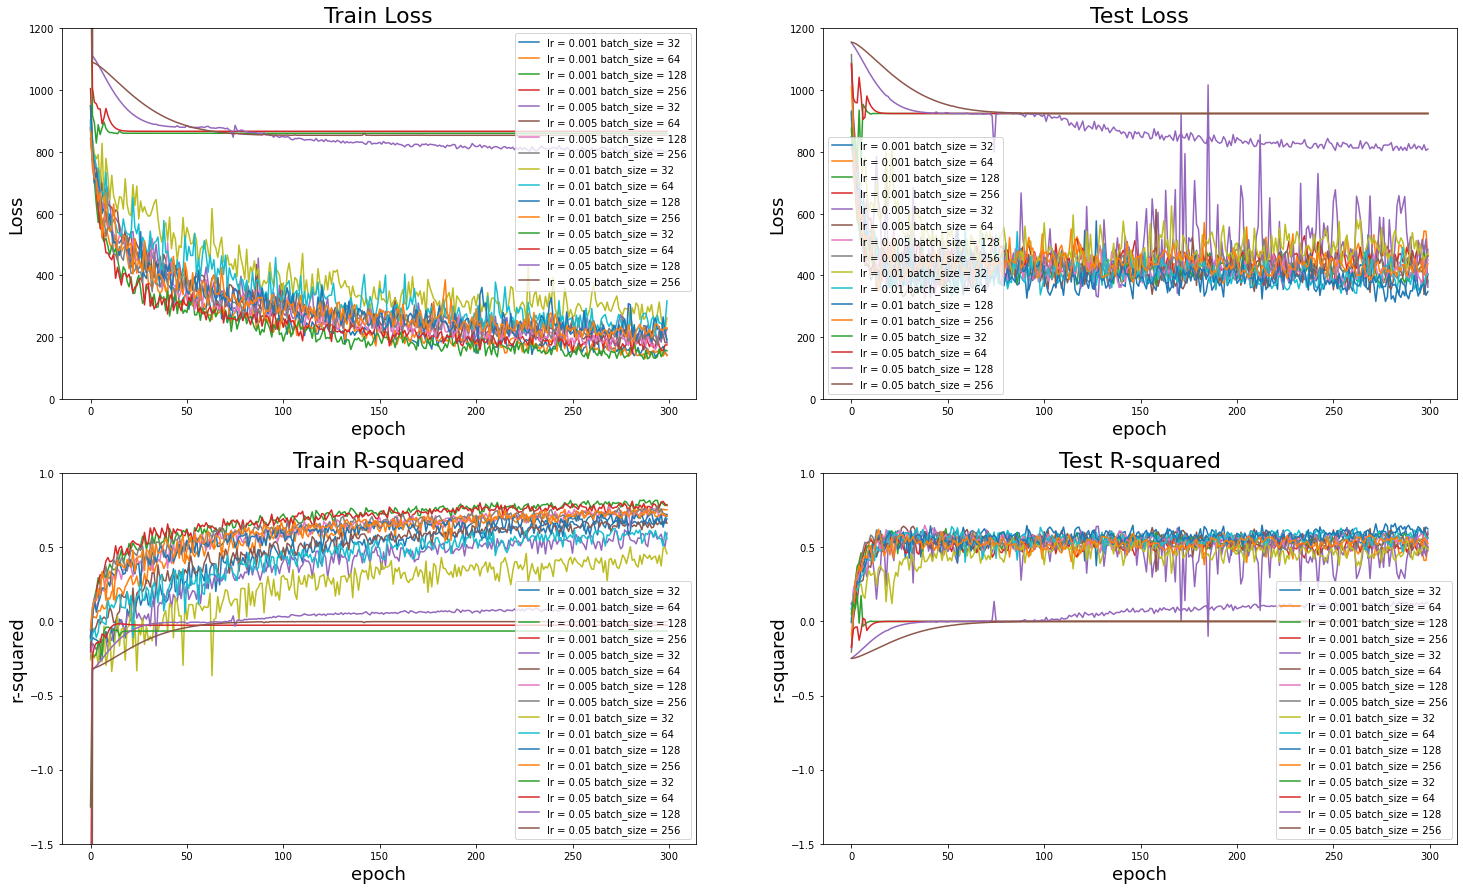

<Figure size 1800x1080 with 0 Axes>

In [11]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1200])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1200])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,1])

plt.show()

In [12]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.6921882969437182
0.7531770273575992
0.7878989855445491
0.7816564668504689
0.5954277010840241
0.6629090452184643
0.7084947800810447
0.7211985217973276
0.45703957857730715
0.5570781952924323
0.7187418852796695
0.7148121828560836
-0.06490232836607002
-0.02559990326310867
0.0924998992539234
-0.00149096893581544
___________________

0.588053465960358
0.5000936249942505
0.5932551886901221
0.498754670743226
0.6083408054011551
0.5623244736013062
0.5092546240927003
0.4759531774226192
0.48906063012555256
0.5613092641493123
0.6233619293026786
0.526494240514448
-7.432546963603848e-05
-7.396537199522157e-05
0.12446115950808267
-3.446861996292405e-05
___________________

142.21530062192446
140.6806788322253
155.92321662902833
175.0305030822754
184.15217441707463
181.8778507526104
227.15963134765624
225.8464111328125
262.6596740128158
317.6997903677133
191.5904998779297
230.30191192626953
860.5925477263215
866.9176013653095
802.8085250854492
853.8950286865235
___________________

380.8089904785156


### 2 best models

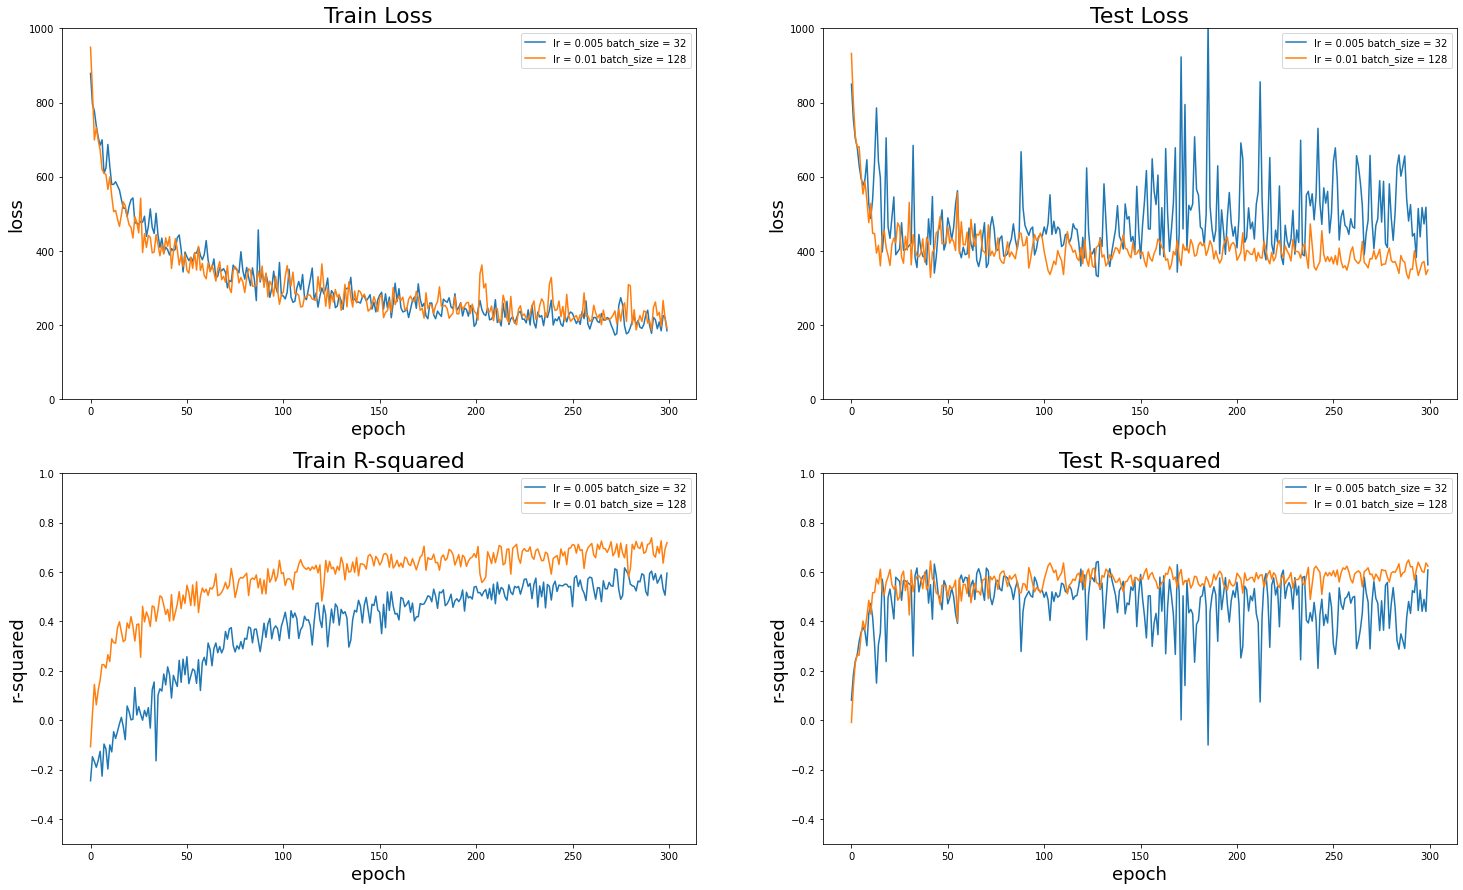

<Figure size 432x288 with 0 Axes>

In [16]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[4],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[10],label="lr = 0.01 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1000])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[4],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[10],label="lr = 0.01 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1000])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[4],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[10],label="lr = 0.01 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[4],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[10],label="lr = 0.01 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 4.2. Training

In [17]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=704, shuffle=False)

In [18]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/caco_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 922.7601914839311, Accuracy: -0.10965588642142593
Test Avg. loss: 1024.3974609375, Accuracy: 0.010730914799198077
################## EPOCH 2 ##################
Train Avg. loss: 837.7864615700462, Accuracy: 0.012655494387105025
Test Avg. loss: 973.2537841796875, Accuracy: 0.06012063875103324
################## EPOCH 3 ##################
Train Avg. loss: 750.1619845303622, Accuracy: 0.11812024100240963
Test Avg. loss: 955.9132690429688, Accuracy: 0.07686655573915435
################## EPOCH 4 ##################
Train Avg. loss: 733.8887981068004, Accuracy: 0.10623213251724307
Test Avg. loss: 868.6012573242188, Accuracy: 0.16118454053546427
################## EPOCH 5 ##################
Train Avg. loss: 702.2082963423295, Accuracy: 0.09448302133494883
Test Avg. loss: 1399.1766357421875, Accuracy: -0.3511964551143698
################## EPOCH 6 ##################
Train Avg. loss: 702.0165696577592, Accuracy: 0.11066242613834615
T

Train Avg. loss: 414.71178158846766, Accuracy: 0.45465566945092317
Test Avg. loss: 644.6296997070312, Accuracy: 0.37747569469765274
################## EPOCH 50 ##################
Train Avg. loss: 370.6255937056108, Accuracy: 0.5326903815747611
Test Avg. loss: 584.3216552734375, Accuracy: 0.43571572064748276
################## EPOCH 51 ##################
Train Avg. loss: 416.59359845248133, Accuracy: 0.4889211410463311
Test Avg. loss: 616.1077880859375, Accuracy: 0.4050195661746673
################## EPOCH 52 ##################
Train Avg. loss: 373.979379827326, Accuracy: 0.5188464049078985
Test Avg. loss: 599.1527099609375, Accuracy: 0.42139324322799854
################## EPOCH 53 ##################
Train Avg. loss: 392.2367005781694, Accuracy: 0.4627426940603386
Test Avg. loss: 659.0098876953125, Accuracy: 0.3635886533483961
################## EPOCH 54 ##################
Train Avg. loss: 468.9191200949929, Accuracy: 0.40905902780718456
Test Avg. loss: 609.4578857421875, Accuracy: 0.41

Train Avg. loss: 319.6393765536222, Accuracy: 0.5749424077216961
Test Avg. loss: 565.83984375, Accuracy: 0.453563821108781
################## EPOCH 97 ##################
Train Avg. loss: 521.4583754106002, Accuracy: 0.39401432675419007
Test Avg. loss: 631.2835083007812, Accuracy: 0.3903643035248915
################## EPOCH 98 ##################
Train Avg. loss: 359.8474419333718, Accuracy: 0.5287773379300746
Test Avg. loss: 549.8684692382812, Accuracy: 0.4689874338753727
################## EPOCH 99 ##################
Train Avg. loss: 403.72938537597656, Accuracy: 0.5044360169500067
Test Avg. loss: 723.3296508789062, Accuracy: 0.3014745443896809
################## EPOCH 100 ##################
Train Avg. loss: 356.2700944380327, Accuracy: 0.5562015216532755
Test Avg. loss: 598.3302001953125, Accuracy: 0.4221875600282453
################## EPOCH 101 ##################
Train Avg. loss: 393.2391877607866, Accuracy: 0.48098572203748324
Test Avg. loss: 594.544921875, Accuracy: 0.4258430141344

Train Avg. loss: 302.8008804321289, Accuracy: 0.5895205180159184
Test Avg. loss: 680.21044921875, Accuracy: 0.3431150873273129
################## EPOCH 145 ##################
Train Avg. loss: 308.7760238647461, Accuracy: 0.6041768427550926
Test Avg. loss: 533.3056640625, Accuracy: 0.48498226366190367
################## EPOCH 146 ##################
Train Avg. loss: 297.2278990312056, Accuracy: 0.5914296258073595
Test Avg. loss: 587.8969116210938, Accuracy: 0.43226306814630233
################## EPOCH 147 ##################
Train Avg. loss: 271.04726271195847, Accuracy: 0.6189686028025201
Test Avg. loss: 559.6209106445312, Accuracy: 0.45956943506121894
################## EPOCH 148 ##################
Train Avg. loss: 279.16640403053975, Accuracy: 0.6243331165997629
Test Avg. loss: 581.0316772460938, Accuracy: 0.43889290230475697
################## EPOCH 149 ##################
Train Avg. loss: 277.8002086986195, Accuracy: 0.5992547356074112
Test Avg. loss: 561.462890625, Accuracy: 0.457790

Train Avg. loss: 293.4069317904386, Accuracy: 0.6247576033919074
Test Avg. loss: 572.8038940429688, Accuracy: 0.44683852643989763
################## EPOCH 193 ##################
Train Avg. loss: 288.64307195490056, Accuracy: 0.6042001101488096
Test Avg. loss: 536.8549194335938, Accuracy: 0.48155474776790486
################## EPOCH 194 ##################
Train Avg. loss: 305.6623597578569, Accuracy: 0.5583418545367675
Test Avg. loss: 536.6170043945312, Accuracy: 0.48178450850989063
################## EPOCH 195 ##################
Train Avg. loss: 317.76562083851206, Accuracy: 0.5839074906630962
Test Avg. loss: 526.4198608398438, Accuracy: 0.49163194494602447
################## EPOCH 196 ##################
Train Avg. loss: 331.386079268022, Accuracy: 0.5778384176849749
Test Avg. loss: 591.6632080078125, Accuracy: 0.4286259174236704
################## EPOCH 197 ##################
Train Avg. loss: 272.41649488969284, Accuracy: 0.6321095245020288
Test Avg. loss: 572.542724609375, Accuracy: 

Train Avg. loss: 251.38017238270152, Accuracy: 0.6595248130761114
Test Avg. loss: 544.8881225585938, Accuracy: 0.47379701412353037
################## EPOCH 240 ##################
Train Avg. loss: 289.12299104170364, Accuracy: 0.6378209674238883
Test Avg. loss: 564.3331909179688, Accuracy: 0.45501873791140923
################## EPOCH 241 ##################
Train Avg. loss: 269.8944272128019, Accuracy: 0.617033007551548
Test Avg. loss: 547.2344970703125, Accuracy: 0.47153105451005584
################## EPOCH 242 ##################
Train Avg. loss: 289.01184116710317, Accuracy: 0.6330720707288678
Test Avg. loss: 560.1408081054688, Accuracy: 0.4590673880186239
################## EPOCH 243 ##################
Train Avg. loss: 261.1520621559837, Accuracy: 0.6130741244434476
Test Avg. loss: 542.8921508789062, Accuracy: 0.4757245482228508
################## EPOCH 244 ##################
Train Avg. loss: 259.4599207097834, Accuracy: 0.6234848797328113
Test Avg. loss: 542.6812744140625, Accuracy: 

Train Avg. loss: 250.99704187566584, Accuracy: 0.6803681661050086
Test Avg. loss: 528.670654296875, Accuracy: 0.48945835788874636
################## EPOCH 287 ##################
Train Avg. loss: 247.86454010009766, Accuracy: 0.6654102312714023
Test Avg. loss: 571.9940185546875, Accuracy: 0.447620609492979
################## EPOCH 288 ##################
Train Avg. loss: 240.67170507257634, Accuracy: 0.6736912974024996
Test Avg. loss: 558.1947021484375, Accuracy: 0.4609467458790111
################## EPOCH 289 ##################
Train Avg. loss: 268.2550031488592, Accuracy: 0.6373805806222911
Test Avg. loss: 627.9856567382812, Accuracy: 0.393549038551533
################## EPOCH 290 ##################
Train Avg. loss: 292.345647985285, Accuracy: 0.6351133592603563
Test Avg. loss: 507.060546875, Accuracy: 0.5103273886552431
################## EPOCH 291 ##################
Train Avg. loss: 249.25790439952505, Accuracy: 0.6572973728966628
Test Avg. loss: 562.132568359375, Accuracy: 0.4571439

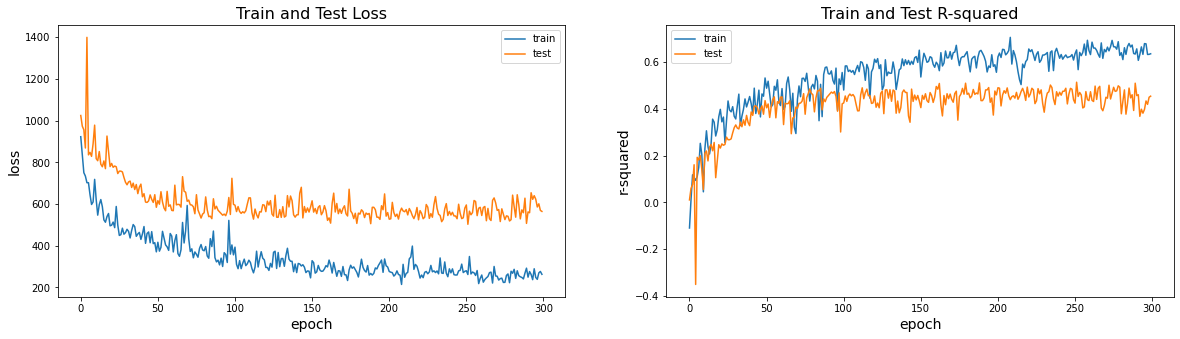

<Figure size 1440x360 with 0 Axes>

In [20]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
plt.show()

In [21]:
model = FCNN()
model.load_state_dict(torch.load('../../models/caco_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 11.044349
MSE: 502.7195
RMSE: 22.421408
R2 Square 0.5145195636257622 

